# EDA Netflix

Elaborado por: Mario Ignacio Ibañez Castro



In [22]:
# 0) Importaciones y configuración

try:
    get_ipython().run_line_magic("matplotlib", "inline")  # asegura gráficos inline
except Exception:
    pass
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
from pathlib import Path
import numpy as np
import pandas as pd
import re, unicodedata, ast
from datetime import datetime

print("backend:", matplotlib.get_backend())

# Si quieres guardar PNGs de respaldo (sin mostrarlos para evitar duplicados)
MOSTRAR_PNG_RESPALDO = False
carpeta_plots = Path("/mnt/data/plots_eda4"); carpeta_plots.mkdir(exist_ok=True, parents=True)

def mostrar_fig(fig, ruta_png=None):
    """Muestra una sola vez la figura. Si MOSTRAR_PNG_RESPALDO=True, guarda PNG (sin mostrar de nuevo)."""
    display(fig)
    if MOSTRAR_PNG_RESPALDO and ruta_png is not None:
        fig.savefig(ruta_png, bbox_inches="tight")
    plt.close(fig)

np.random.seed(42)  # reproducibilidad


backend: module://matplotlib_inline.backend_inline


## 1) Carga de archivos (sin cambiar tus nombres) 
Se cargan los CSV a las **mismas** variables que usas: `data_netflix`, `actores`, `mejores_peliculas`, `mejores_shows`.
La lectura es tolerante a encoding y separador.

In [23]:
base_dir = Path(r"C:\Users\mario\Downloads\PRUEBA_BI BOOSTER\00_Datos")

rutas = {
    "data_netflix": base_dir / "data_netflix.csv",
    "actores": base_dir / "Actores.csv",
    "mejores_peliculas": base_dir / "mejores peliculas Netflix.csv",
    "mejores_shows": base_dir / "mejores Shows Netflix.csv",
}

def leer_csv_tolerante(path):
    """Lee CSV probando encoding y separadores comunes, sin romper si hay BOM/acentos."""
    encodings = ["utf-8", "utf-8-sig", "latin-1"]
    seps = [",", ";", "\t"]
    ultimo_error = None
    for enc in encodings:
        for sep in seps:
            try:
                df = pd.read_csv(path, encoding=enc, sep=sep, engine="python")
                # heurística: evitar leer todo en una sola columna por mal separador
                if df.shape[1] == 1 and sep != "\t":
                    continue
                return df
            except Exception as e:
                ultimo_error = e
                continue
    raise RuntimeError(f"No se pudo leer {path}: {ultimo_error}")

# Carga con nombres
data_netflix = leer_csv_tolerante(rutas["data_netflix"]) if rutas["data_netflix"].exists() else None
actores = leer_csv_tolerante(rutas["actores"]) if rutas["actores"].exists() else None
mejores_peliculas = leer_csv_tolerante(rutas["mejores_peliculas"]) if rutas["mejores_peliculas"].exists() else None
mejores_shows = leer_csv_tolerante(rutas["mejores_shows"]) if rutas["mejores_shows"].exists() else None

tablas = {k:v for k,v in {
    "data_netflix": data_netflix,
    "actores": actores,
    "mejores_peliculas": mejores_peliculas,
    "mejores_shows": mejores_shows,
}.items() if v is not None}

print("Tablas cargadas:", list(tablas.keys()))
for nombre, df in tablas.items():
    print(f"\n=== {nombre.upper()} ===")
    print("shape:", df.shape)
    display(df.head(3))
    display(df.dtypes.to_frame("dtype").T)

assert "data_netflix" in tablas, "Falta data_netflix.csv en /mnt/data"


Tablas cargadas: ['data_netflix', 'actores', 'mejores_peliculas', 'mejores_shows']

=== DATA_NETFLIX ===
shape: (5806, 12)


,id,title,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes
0,ts300399,Five Came Back: The Reference Films,SHOW,1945,TV-MA,48,['documentation'],['US'],1.0,NaN,NaN,NaN
1,tm84618,Taxi Driver,MOVIE,1976,R,113,"['crime', 'drama']",['US'],NaN,tt0075314,8.3,795222.0
2,tm127384,Monty Python and the Holy Grail,MOVIE,1975,PG,91,"['comedy', 'fantasy']",['GB'],NaN,tt0071853,8.2,530877.0


,id,title,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes
dtype,object,object,object,int64,object,int64,object,object,float64,object,float64,float64



=== ACTORES ===
shape: (77213, 5)


,person_id,id,name,character,role
0,3748,tm84618,Robert De Niro,Travis Bickle,ACTOR
1,14658,tm84618,Jodie Foster,Iris Steensma,ACTOR
2,7064,tm84618,Albert Brooks,Tom,ACTOR


,person_id,id,name,character,role
dtype,int64,object,object,object,object



=== MEJORES_PELICULAS ===
shape: (387, 7)


,TITLE,RELEASE_YEAR,SCORE,NUMBER_OF_VOTES,DURATION,MAIN_GENRE,MAIN_PRODUCTION
0,David Attenborough: A Life on Our Planet,2020,9.0,31180,83,documentary,GB
1,Inception,2010,8.8,2268288,148,scifi,GB
2,Forrest Gump,1994,8.8,1994599,142,drama,US


,TITLE,RELEASE_YEAR,SCORE,NUMBER_OF_VOTES,DURATION,MAIN_GENRE,MAIN_PRODUCTION
dtype,object,int64,float64,int64,int64,object,object



=== MEJORES_SHOWS ===
shape: (246, 8)


,TITLE,RELEASE_YEAR,SCORE,NUMBER_OF_VOTES,DURATION,NUMBER_OF_SEASONS,MAIN_GENRE,MAIN_PRODUCTION
0,Breaking Bad,2008,9.5,1727694,48,5,drama,US
1,Avatar: The Last Airbender,2005,9.3,297336,24,3,scifi,US
2,Our Planet,2019,9.3,41386,50,1,documentary,GB


,TITLE,RELEASE_YEAR,SCORE,NUMBER_OF_VOTES,DURATION,NUMBER_OF_SEASONS,MAIN_GENRE,MAIN_PRODUCTION
dtype,object,int64,float64,int64,int64,int64,object,object


Comentarios del punto 1)
- Lectura **tolerante** de los 4 CSV (encoding y separador) → evita fallas de carga y columnas “pegadas”.
- Los objetos quedan con **tus mismos nombres** (`data_netflix`, `actores`, `mejores_peliculas`, `mejores_shows`), listo para trabajar sin refactors.

## 2) Utilidades
Funciones para normalizar títulos, crear vistas estandarizadas y medir calidad.

In [24]:
def norm_title(s):
    if pd.isna(s): return s
    s = unicodedata.normalize("NFKD", str(s)).encode("ascii","ignore").decode("ascii")
    s = re.sub(r"[^a-z0-9 ]+", " ", s.lower())
    s = re.sub(r"\s+", " ", s).strip()
    return s

def vista_estandar(df, mapping):
    """Crea una vista con nombres comunes SOLO para medir (no altera el df original)."""
    d = df.rename(columns={k:v for k,v in mapping.items() if k in df.columns}).copy()
    keep = [c for c in ["title","release_year","imdb_score","imdb_votes","runtime","seasons","main_genre","type","imdb_id","genres","production_countries"] if c in d.columns]
    d = d[keep]
    if {"title","release_year"}.issubset(d.columns):
        d["title_norm"] = d["title"].map(norm_title)
    # no convertimos tipos aquí;
    return d

def cobertura_llave(df):
    if not set(["title","release_year"]).issubset(df.columns):
        return None
    total = len(df)
    validos = df["title"].notna() & df["title"].astype(str).str.strip().ne("") & df["release_year"].notna()
    return {
        "filas": total,
        "con_title_y_year": int(validos.sum()),
        "pct_cobertura": round(validos.mean()*100, 2),
        "duplicados_por_llave": int(df[validos].duplicated(subset=["title","release_year"]).sum()),
    }

def revisar_reglas(df, nombre):
    viol = {}
    if "imdb_score" in df.columns:
        v = df[~pd.to_numeric(df["imdb_score"], errors="coerce").between(0,10, inclusive="both") & df["imdb_score"].notna()]
        viol["imdb_score_fuera_0_10"] = len(v)
    if "imdb_votes" in df.columns:
        vv = pd.to_numeric(df["imdb_votes"], errors="coerce")
        v = df[(vv < 0) & df["imdb_votes"].notna()]
        viol["imdb_votes_negativos"] = len(v)
    if "runtime" in df.columns:
        rr = pd.to_numeric(df["runtime"], errors="coerce")
        v = df[~rr.between(1, 600, inclusive="both") & df["runtime"].notna()]
        viol["runtime_fuera_1_600"] = len(v)
    if "seasons" in df.columns:
        ss = pd.to_numeric(df["seasons"], errors="coerce")
        v = df[(ss < 0) & df["seasons"].notna()]
        viol["seasons_negativas"] = len(v)
    if "release_year" in df.columns:
        ry = pd.to_numeric(df["release_year"], errors="coerce")
        v = df[(ry < 1900) & df["release_year"].notna()]
        viol["release_year_menor_1900"] = len(v)
    if "title" in df.columns:
        v = df[df["title"].astype(str).str.strip().eq("")]
        viol["title_vacio"] = len(v)
    if nombre.lower().startswith("actor") or nombre=="df_actors" or nombre=="actores":
        for c in [x for x in ["name","character","role"] if x in df.columns]:
            blancos = df[c].astype(str).str.strip().eq("").sum()
            nulos   = df[c].isna().sum()
            viol[f"{c}_blancos"] = int(blancos)
            viol[f"{c}_nulos"]   = int(nulos)
    return pd.Series(viol, name=nombre)


Comentarios del punto 2)
- Se definen utilidades sin tocar los DataFrames: normalización de títulos (`title_norm`) y “vistas” para medir.
- **Decisión de diseño**: toda transformación “fuerte” se reserva para el ETL; aquí solo medimos.

## 3) Vistas estandarizadas para medi

Sirven para correlacionar columnas con nombres distintos entre archivos (ej. `TITLE` → `title`).

In [25]:
vistas = {}
if "data_netflix" in tablas:
    vistas["data_netflix"] = vista_estandar(tablas["data_netflix"], {})
if "mejores_peliculas" in tablas:
    vistas["mejores_peliculas"] = vista_estandar(tablas["mejores_peliculas"], {
        "TITLE":"title","RELEASE_YEAR":"release_year","SCORE":"imdb_score",
        "NUMBER_OF_VOTES":"imdb_votes","DURATION":"runtime","MAIN_GENRE":"main_genre","TYPE":"type","IMDB_ID":"imdb_id"
    })
if "mejores_shows" in tablas:
    vistas["mejores_shows"] = vista_estandar(tablas["mejores_shows"], {
        "TITLE":"title","RELEASE_YEAR":"release_year","SCORE":"imdb_score",
        "NUMBER_OF_VOTES":"imdb_votes","DURATION":"runtime","NUMBER_OF_SEASONS":"seasons",
        "MAIN_GENRE":"main_genre","TYPE":"type","IMDB_ID":"imdb_id"
    })

print("Vistas disponibles:", list(vistas.keys()))


Vistas disponibles: ['data_netflix', 'mejores_peliculas', 'mejores_shows']


Comentarios del punto 3)
- Las **vistas estandarizadas** alinean columnas heterogéneas (`TITLE`→`title`, etc.) para poder comparar bases.
- `title_norm` (minúsculas, sin acentos/ruido) incrementa la **chance de match** en cruces entre archivos.

## 4) Diagnóstico base: duplicados exactos, nulos, reglas y cobertura de llave

In [26]:
# Duplicados exactos (todas las columnas)
for nombre, df in tablas.items():
    dups = df[df.duplicated(keep=False)]
    print(f"\n=== {nombre.upper()} — duplicados exactos === filas:", len(dups))
    display(dups.head(10))

# Nulos por columna (Top 20)
for nombre, df in tablas.items():
    print(f"\n=== {nombre.upper()} — nulos por columna (Top 20) ===")
    pct = (df.isna().mean().sort_values(ascending=False)*100).round(2).rename("pct_nulos")
    display(pct.head(20).to_frame())

# Reglas de negocio
res = []
for nombre, df in tablas.items():
    res.append(revisar_reglas(df, nombre))
resumen_reglas = pd.concat(res, axis=1).fillna(0).astype(int).T if res else pd.DataFrame()
print("\n=== Resumen reglas de negocio (violaciones) ===")
display(resumen_reglas)

# Cobertura de llave title+release_year
for nombre, df in vistas.items():
    info = cobertura_llave(df)
    if info:
        print(f"\n=== {nombre.upper()} — cobertura llave title+release_year ===")
        for k,v in info.items():
            print(f"{k}: {v}")



=== DATA_NETFLIX — duplicados exactos === filas: 0


,id,title,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes



=== ACTORES — duplicados exactos === filas: 0


,person_id,id,name,character,role



=== MEJORES_PELICULAS — duplicados exactos === filas: 0


,TITLE,RELEASE_YEAR,SCORE,NUMBER_OF_VOTES,DURATION,MAIN_GENRE,MAIN_PRODUCTION



=== MEJORES_SHOWS — duplicados exactos === filas: 0


,TITLE,RELEASE_YEAR,SCORE,NUMBER_OF_VOTES,DURATION,NUMBER_OF_SEASONS,MAIN_GENRE,MAIN_PRODUCTION



=== DATA_NETFLIX — nulos por columna (Top 20) ===


,pct_nulos
seasons,64.74
age_certification,44.95
imdb_votes,9.28
imdb_score,9.01
imdb_id,7.65
title,0.02
id,0.00
type,0.00
release_year,0.00
runtime,0.00



=== ACTORES — nulos por columna (Top 20) ===


,pct_nulos
character,12.47
person_id,0.00
id,0.00
name,0.00
role,0.00



=== MEJORES_PELICULAS — nulos por columna (Top 20) ===


,pct_nulos
TITLE,0.0
RELEASE_YEAR,0.0
SCORE,0.0
NUMBER_OF_VOTES,0.0
DURATION,0.0
MAIN_GENRE,0.0
MAIN_PRODUCTION,0.0



=== MEJORES_SHOWS — nulos por columna (Top 20) ===


,pct_nulos
TITLE,0.0
RELEASE_YEAR,0.0
SCORE,0.0
NUMBER_OF_VOTES,0.0
DURATION,0.0
NUMBER_OF_SEASONS,0.0
MAIN_GENRE,0.0
MAIN_PRODUCTION,0.0



=== Resumen reglas de negocio (violaciones) ===


,imdb_score_fuera_0_10,imdb_votes_negativos,runtime_fuera_1_600,seasons_negativas,release_year_menor_1900,title_vacio,name_blancos,name_nulos,character_blancos,character_nulos,role_blancos,role_nulos
data_netflix,0,0,24,0,0,0,0,0,0,0,0,0
actores,0,0,0,0,0,0,0,0,0,9627,0,0
mejores_peliculas,0,0,0,0,0,0,0,0,0,0,0,0
mejores_shows,0,0,0,0,0,0,0,0,0,0,0,0



=== DATA_NETFLIX — cobertura llave title+release_year ===
filas: 5806
con_title_y_year: 5805
pct_cobertura: 99.98
duplicados_por_llave: 4

=== MEJORES_PELICULAS — cobertura llave title+release_year ===
filas: 387
con_title_y_year: 387
pct_cobertura: 100.0
duplicados_por_llave: 0

=== MEJORES_SHOWS — cobertura llave title+release_year ===
filas: 246
con_title_y_year: 246
pct_cobertura: 100.0
duplicados_por_llave: 0


Comentarios del punto 4)
- `data_netflix` **5,806** filas; **0** duplicados exactos → calidad estructural buena.
- Faltantes relevantes: **imdb_score 9.01%**, **imdb_votes 9.28%**, **age_certification 44.95%**, **imdb_id 7.65%**; `runtime` completo.

## 5) Gráficas básicas (crudo) 
Histogramas de métricas, barras de categóricas y conteo por año.

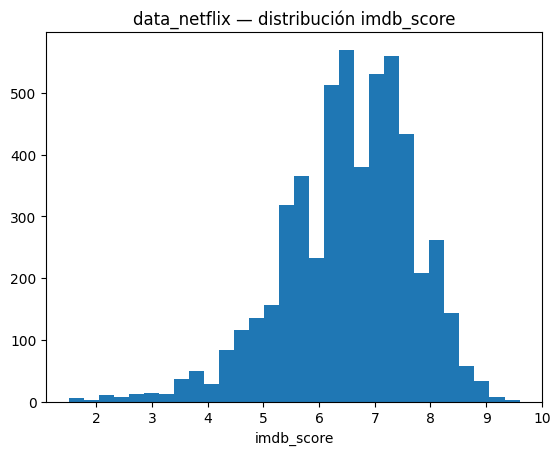

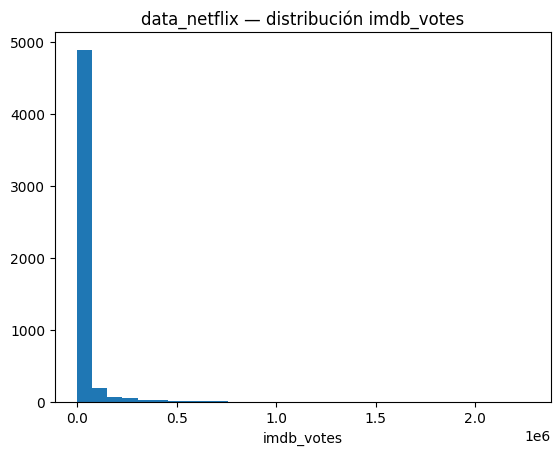

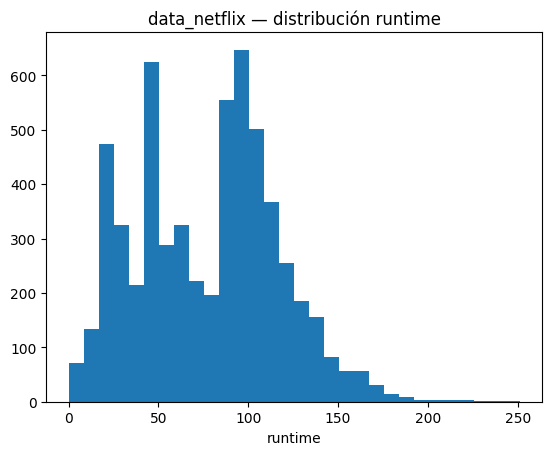

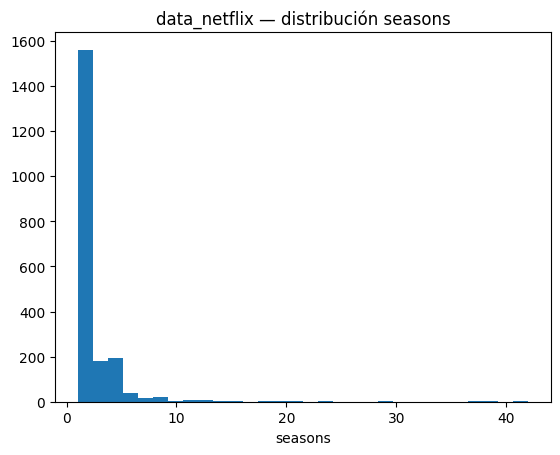

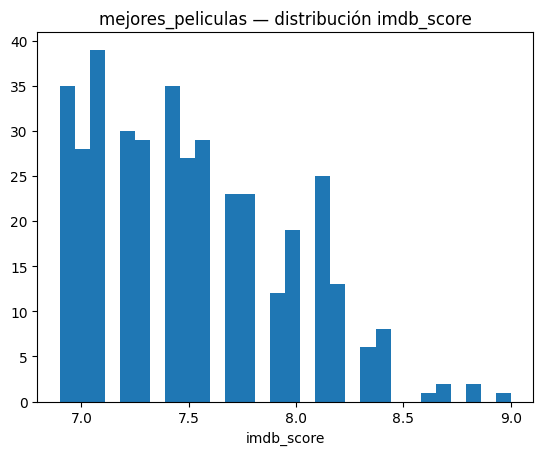

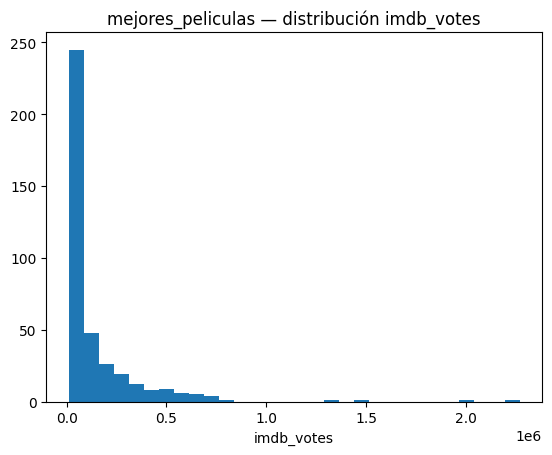

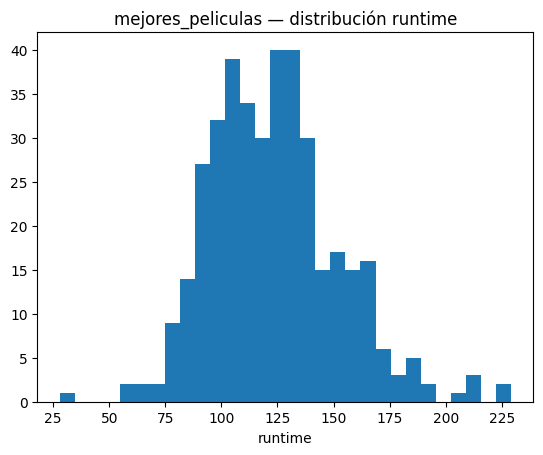

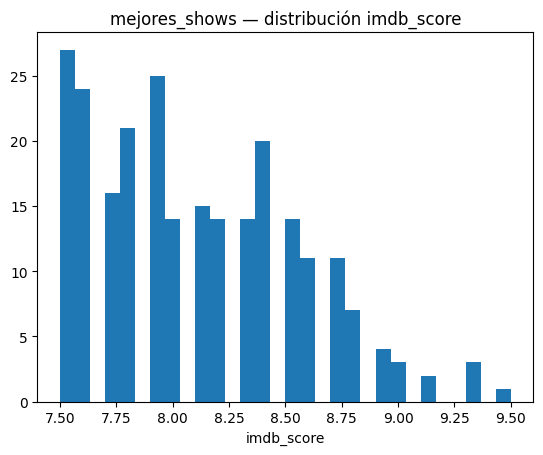

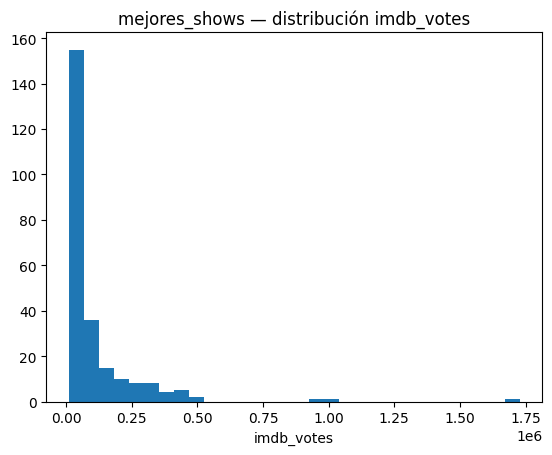

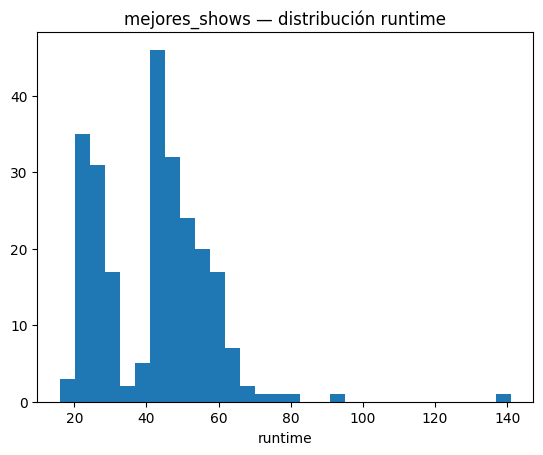

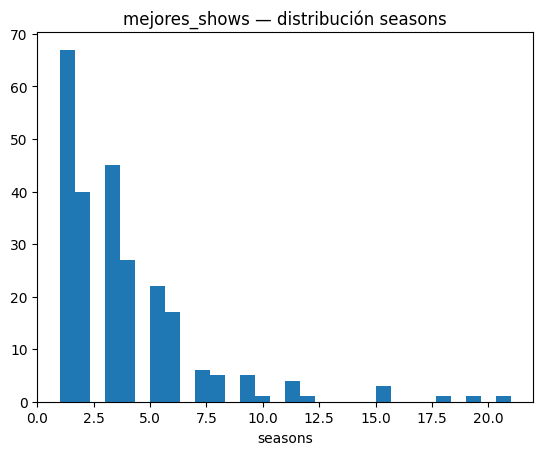

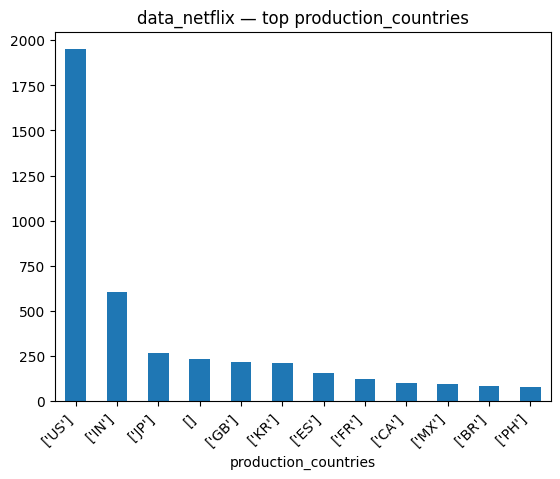

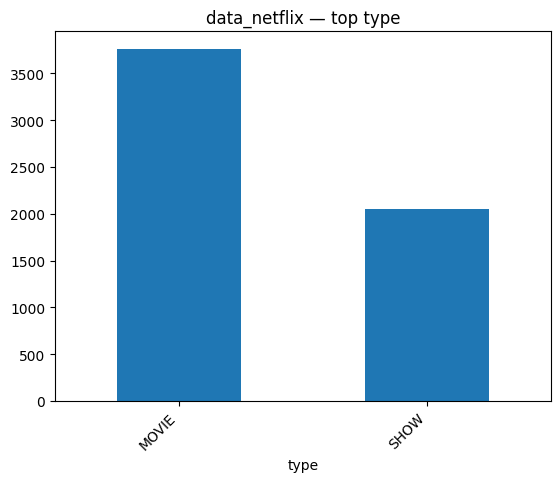

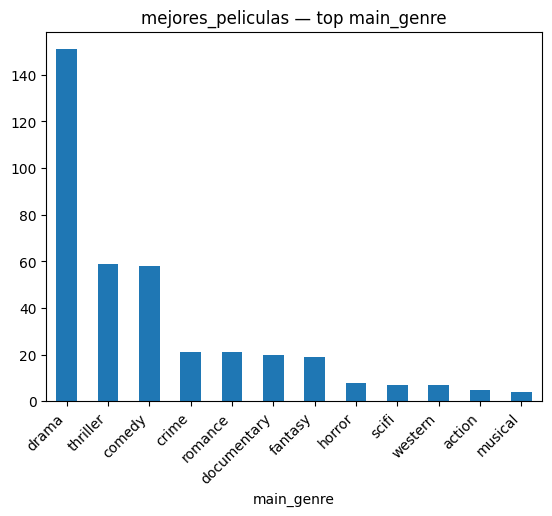

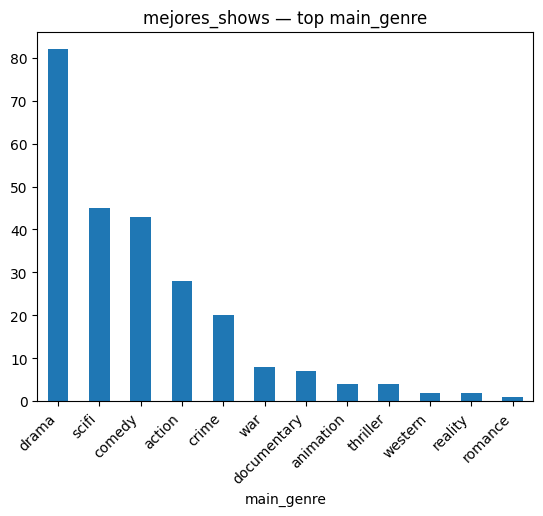

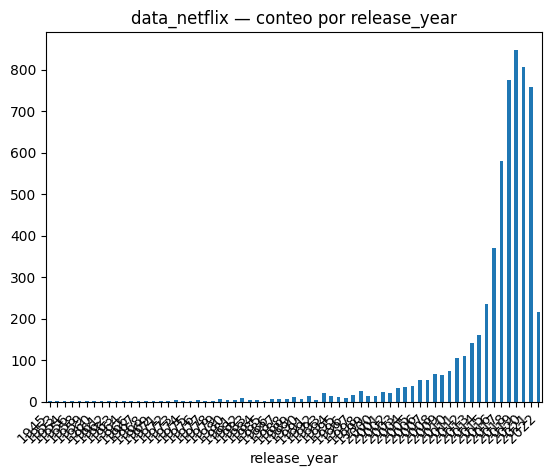

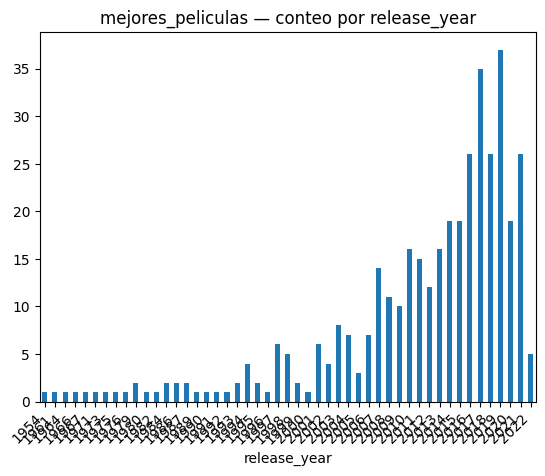

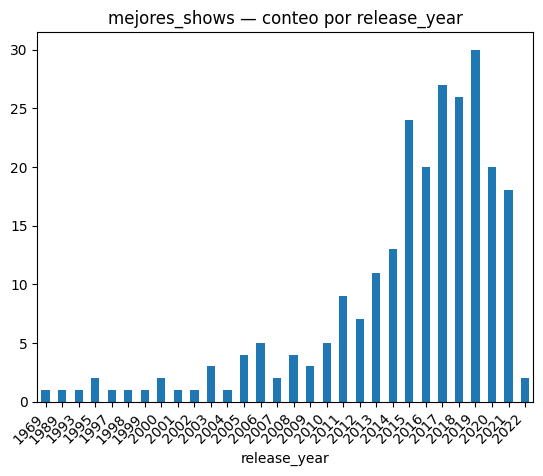

In [27]:
def serie_numerica(df, c):
    return pd.to_numeric(df[c], errors="coerce") if c in df.columns else pd.Series(dtype=float)

metricas = ["imdb_score","imdb_votes","runtime","seasons"]
for nombre, df in vistas.items():
    cols = [c for c in metricas if c in df.columns]
    for c in cols:
        s = serie_numerica(df, c).dropna()
        if s.empty: continue
        fig, ax = plt.subplots(); ax.hist(s, bins=30)
        ax.set_title(f"{nombre} — distribución {c}"); ax.set_xlabel(c)
        mostrar_fig(fig, carpeta_plots / f"{nombre}_{c}_hist.png")

categoricas = ["main_genre","production_countries","age_certification","type"]
for nombre, df in vistas.items():
    for c in [x for x in categoricas if x in df.columns]:
        conteo = df[c].fillna("desconocido").astype(str).str.strip()
        conteo = conteo[conteo.ne("")].value_counts().head(12)
        if conteo.empty: continue
        fig, ax = plt.subplots(); conteo.plot(kind="bar", ax=ax, title=f"{nombre} — top {c}")
        plt.xticks(rotation=45, ha="right")
        mostrar_fig(fig, carpeta_plots / f"{nombre}_top_{c}.png")

for nombre, df in vistas.items():
    if "release_year" not in df.columns: continue
    conteo = pd.to_numeric(df["release_year"], errors="coerce").dropna().astype(int).value_counts().sort_index()
    if conteo.empty: continue
    fig, ax = plt.subplots(); conteo.plot(kind="bar", ax=ax, title=f"{nombre} — conteo por release_year")
    plt.xticks(rotation=45, ha="right")
    mostrar_fig(fig, carpeta_plots / f"{nombre}_por_release_year.png")


Comentarios del punto 5)
- Histogramas muestran `imdb_score` **centrado en 6–7** con cola a la derecha; `imdb_votes` **cola pesada** (pocos muy populares).
- Barras por categóricas revelan **alta concentración** en pocos géneros/países y **larga cola** de categorías raras (recomendable Top-N).

## 6) Correlación y estratificados 
Heatmap numérico y histogramas por `type` / `main_genre` (Top 8).

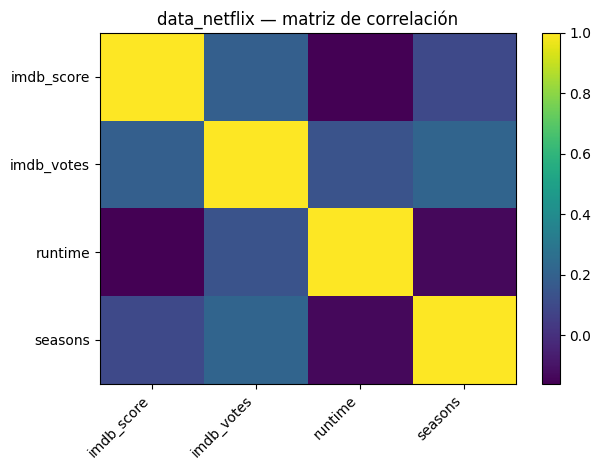

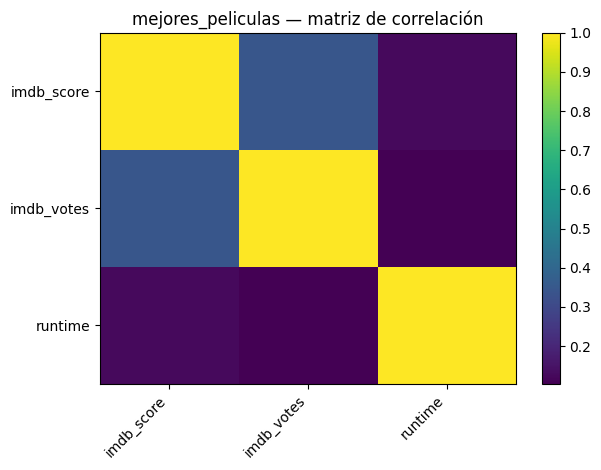

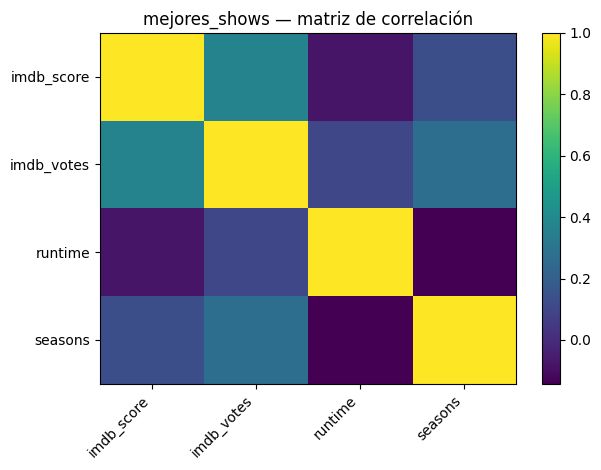

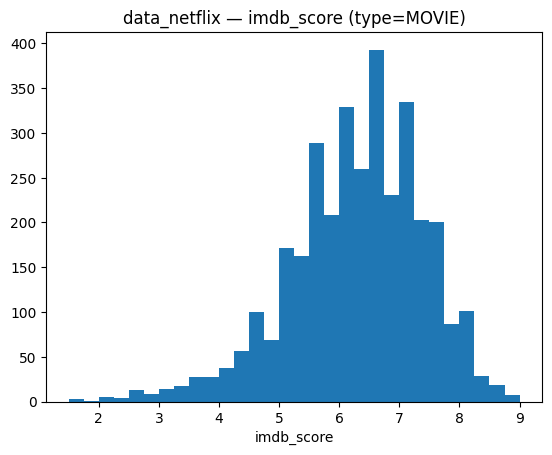

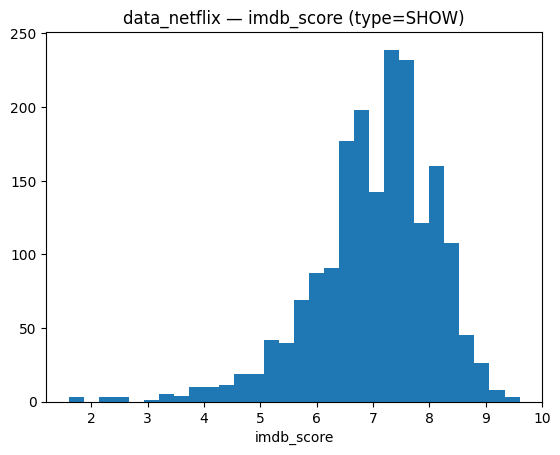

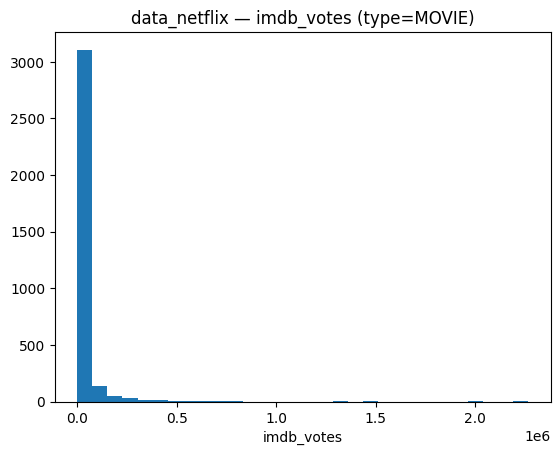

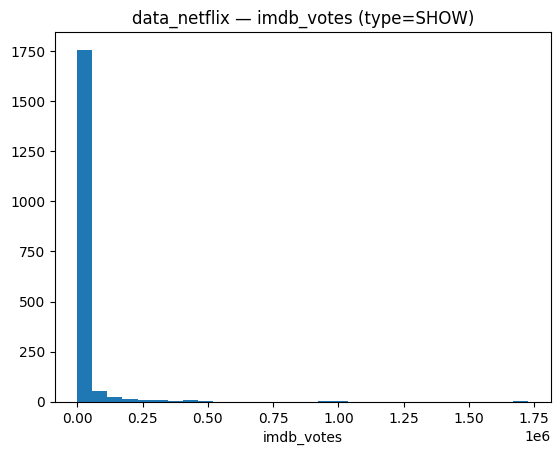

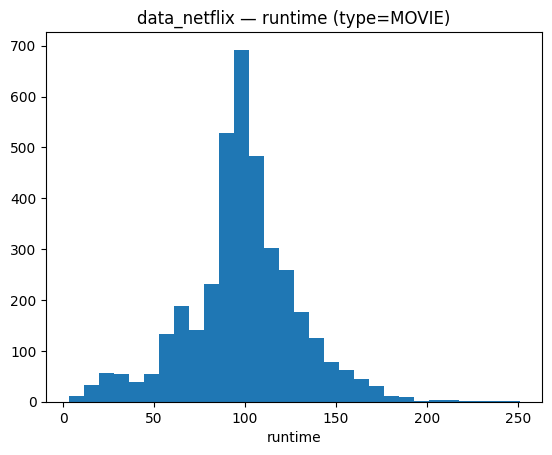

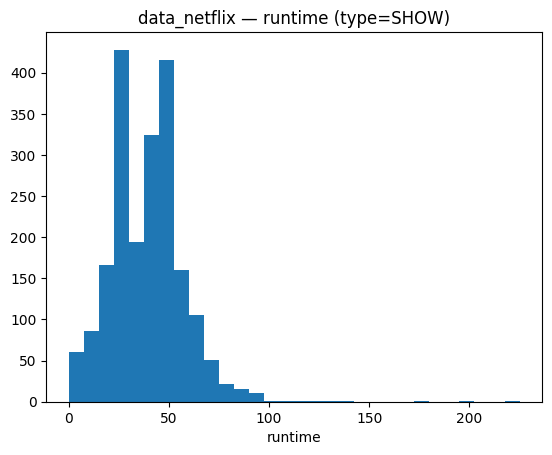

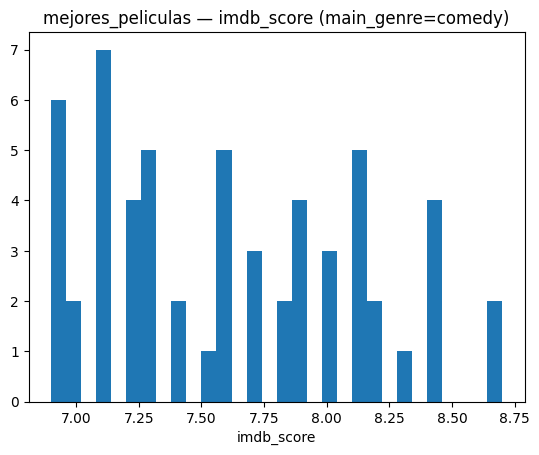

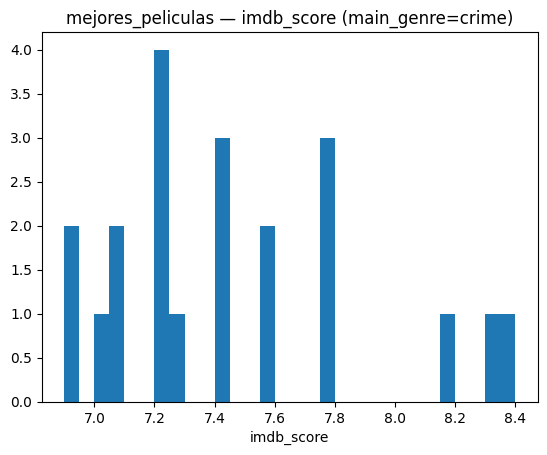

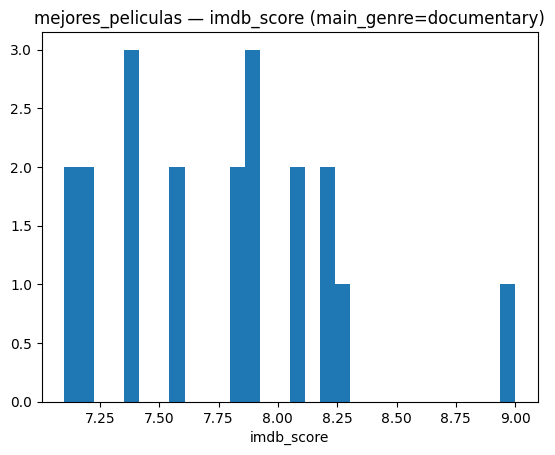

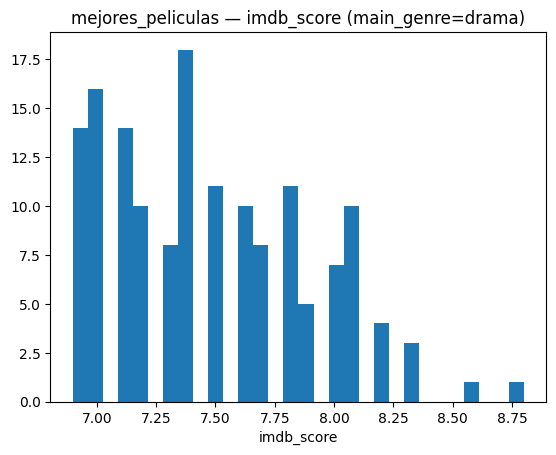

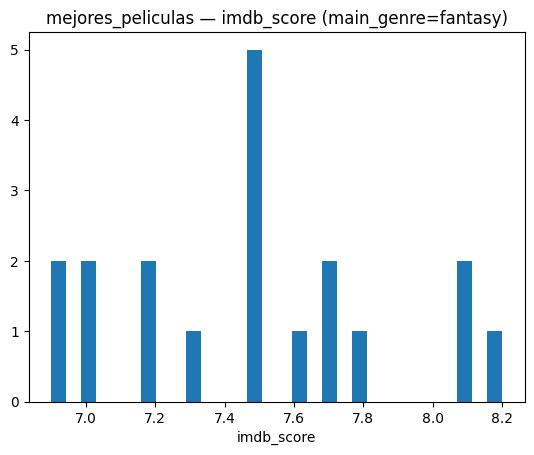

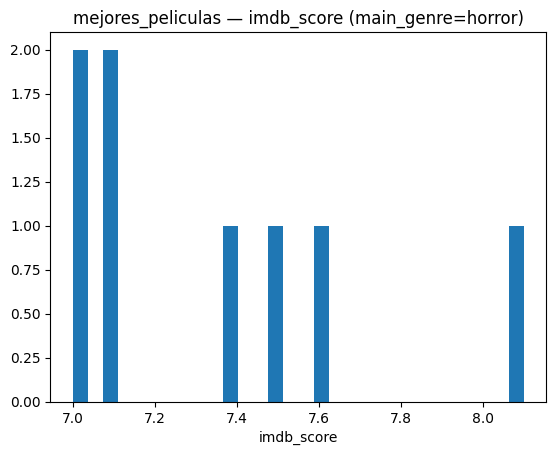

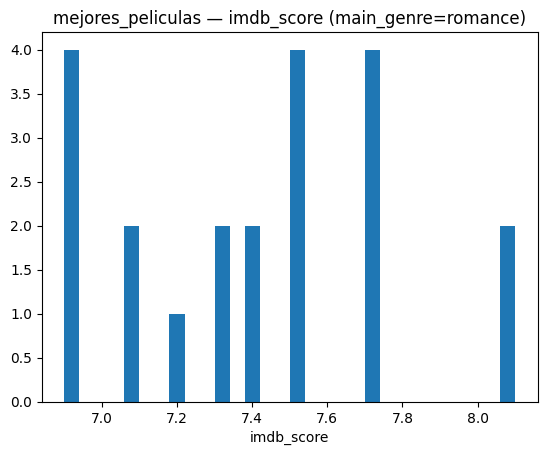

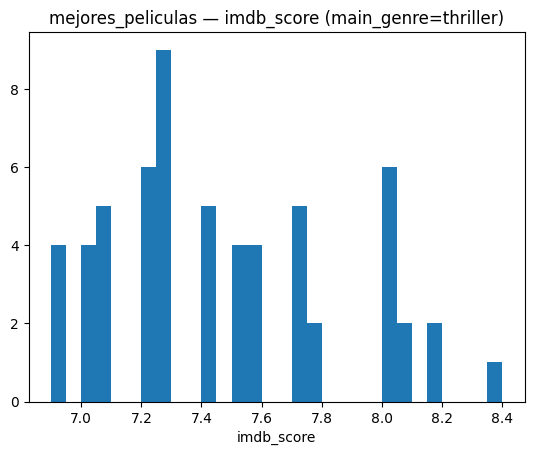

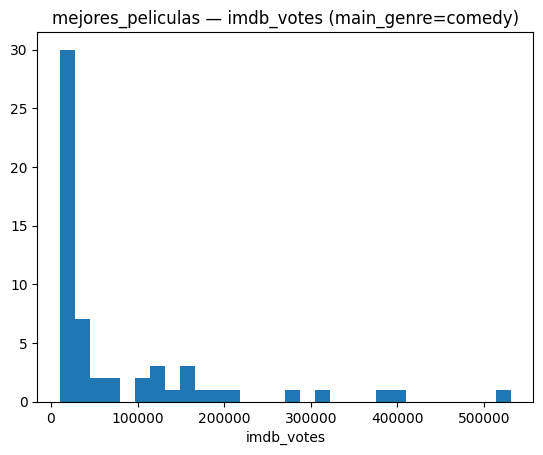

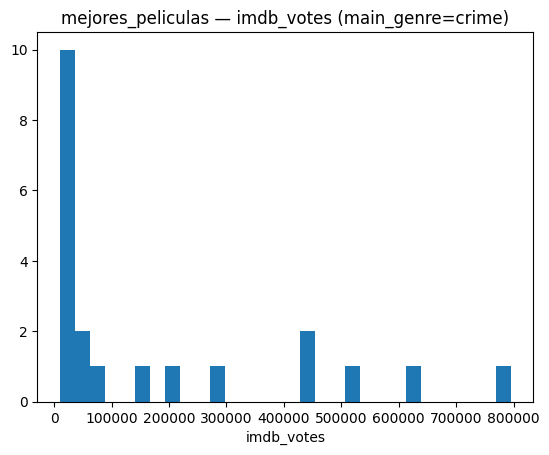

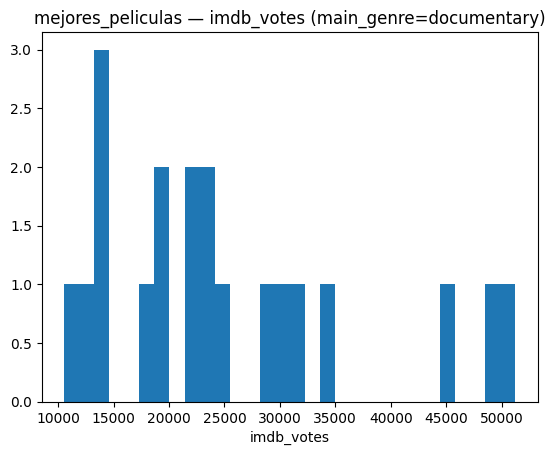

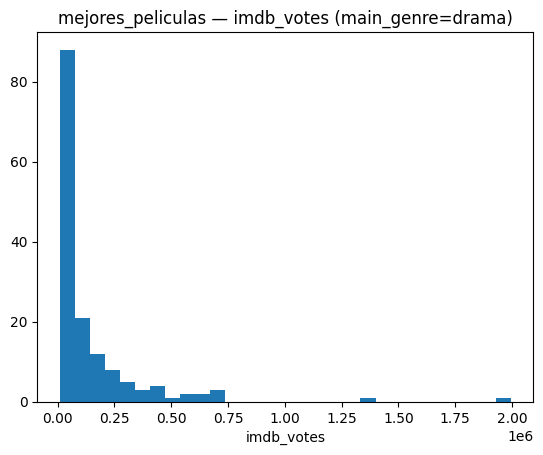

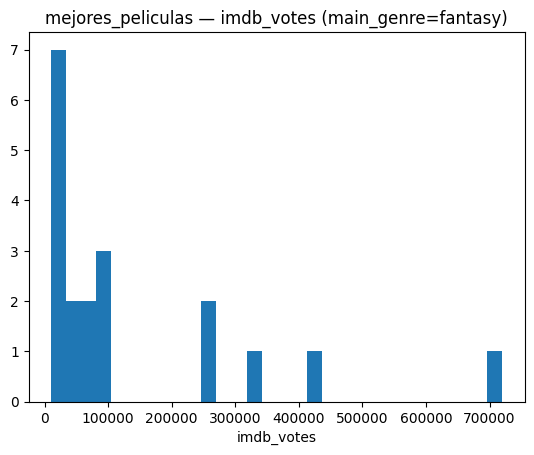

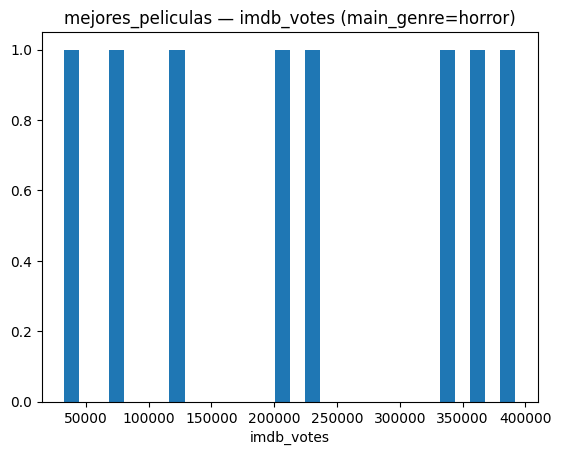

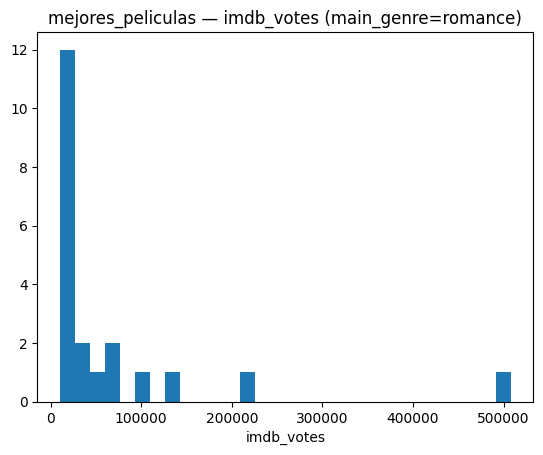

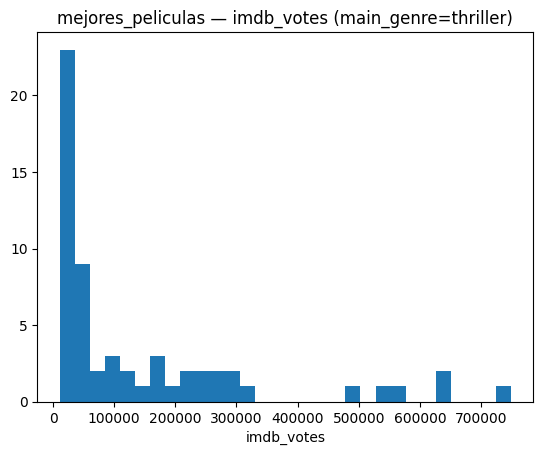

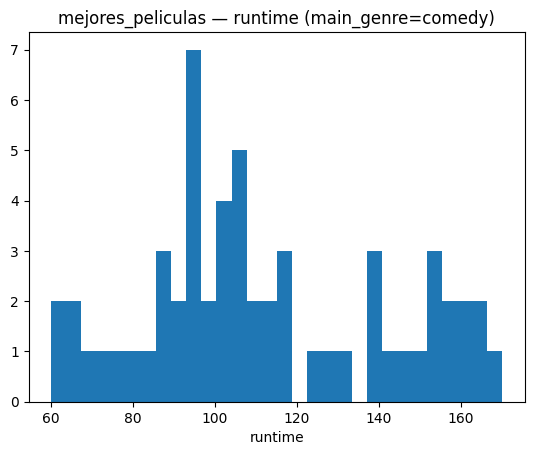

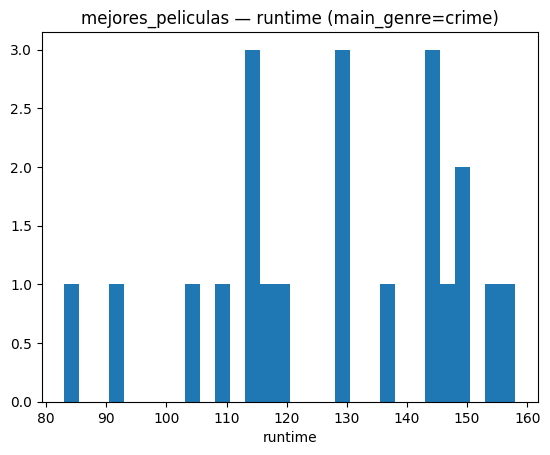

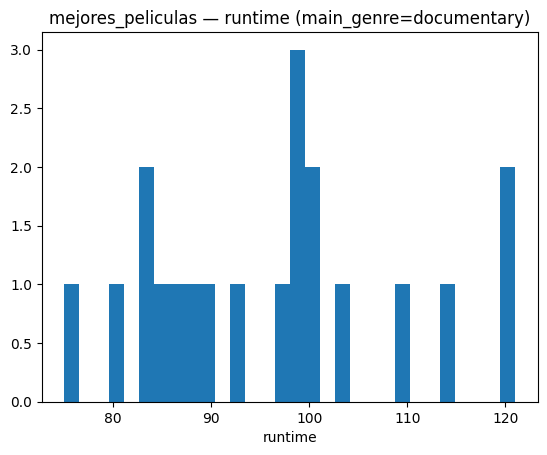

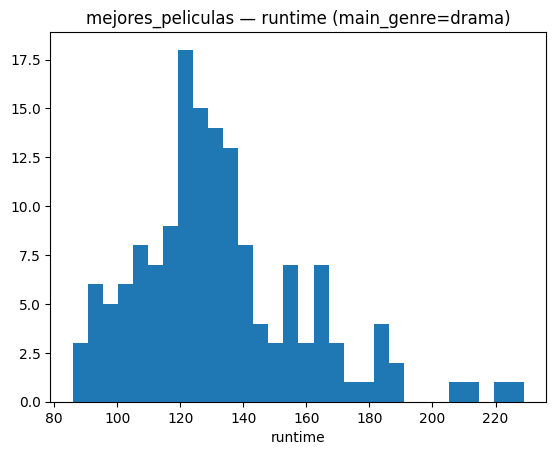

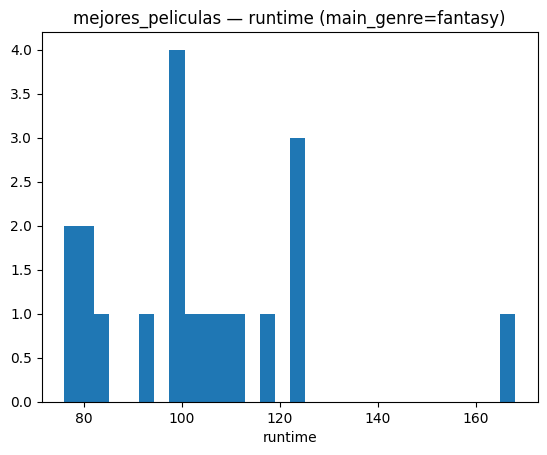

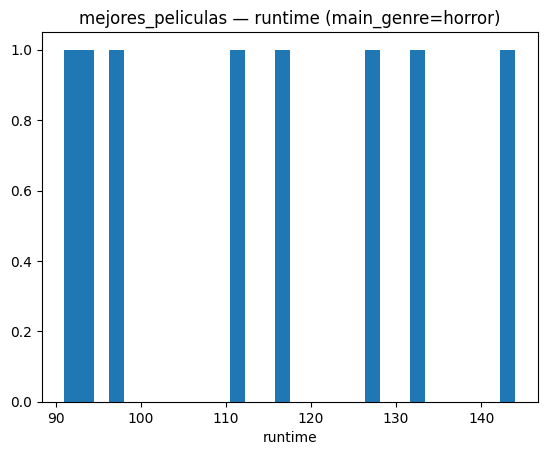

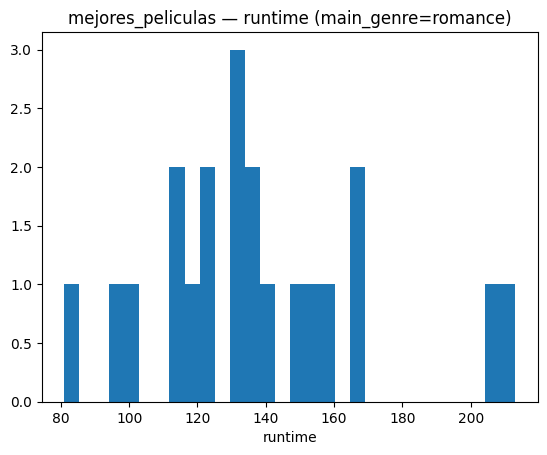

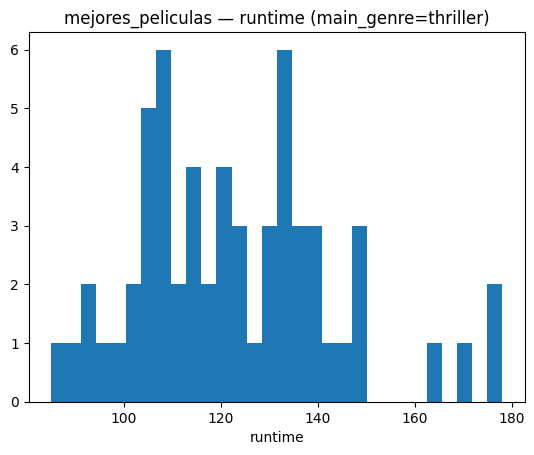

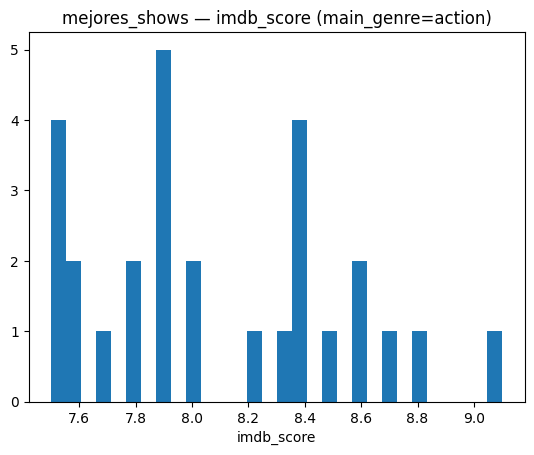

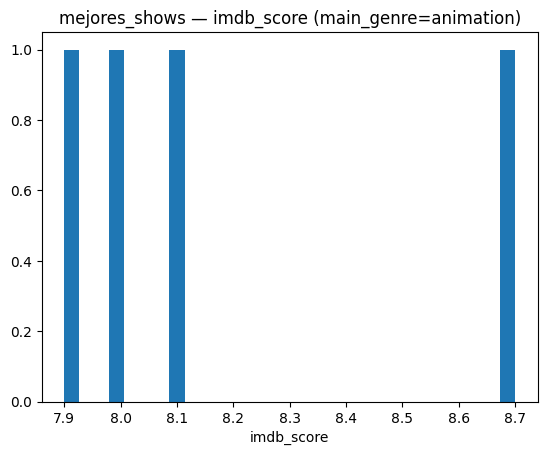

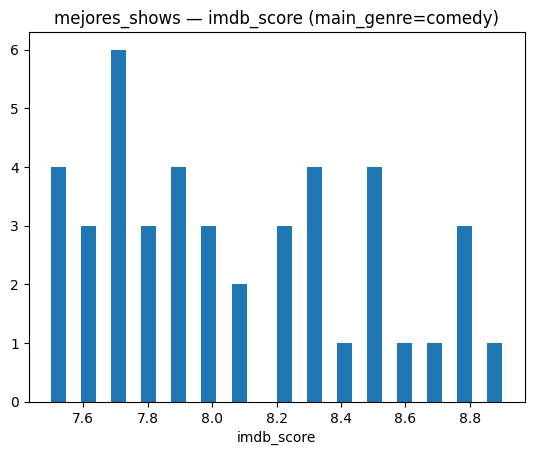

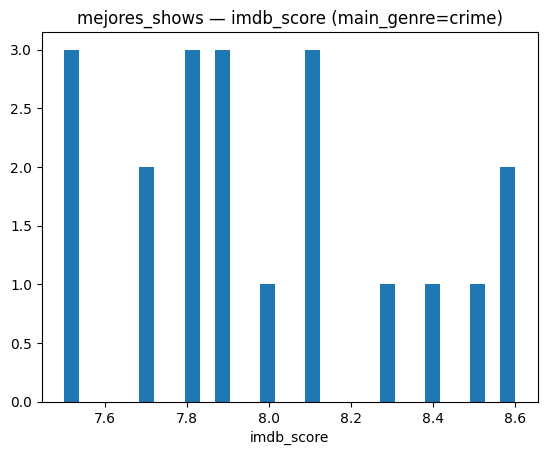

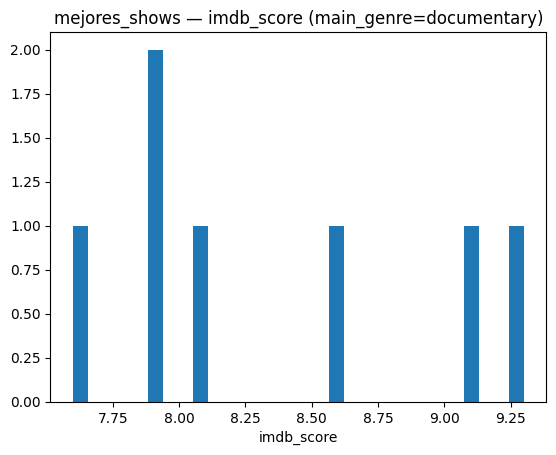

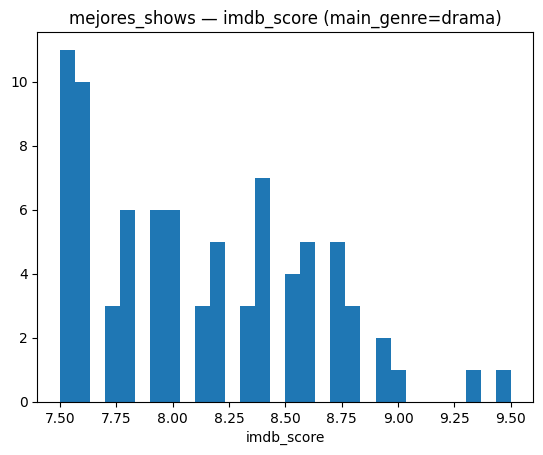

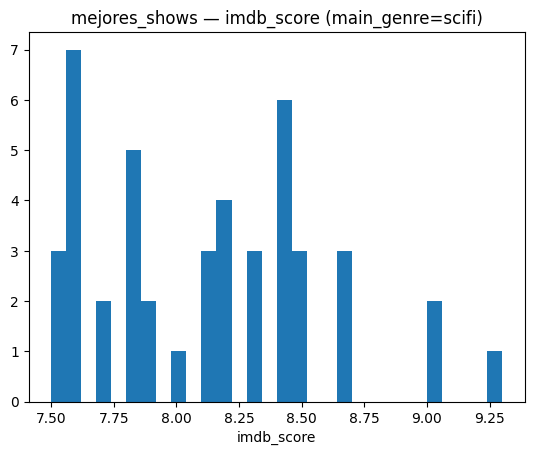

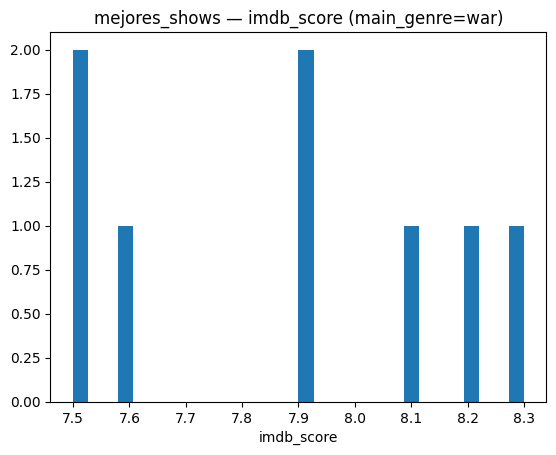

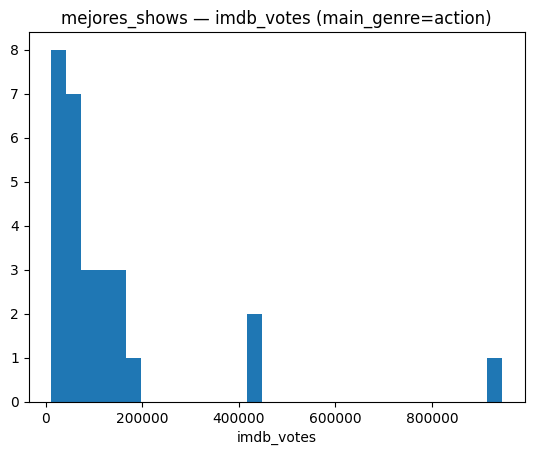

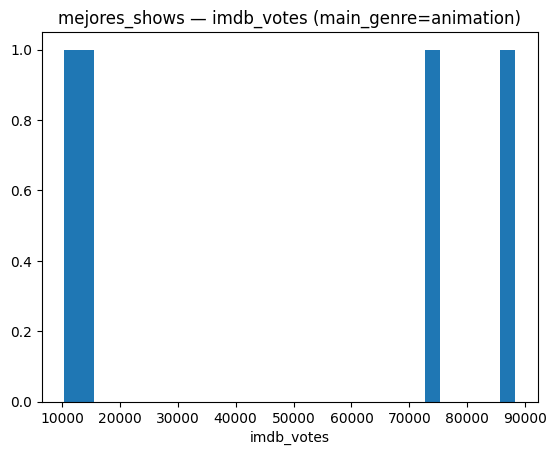

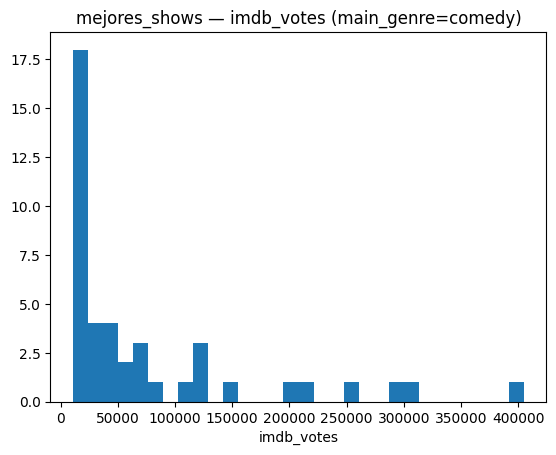

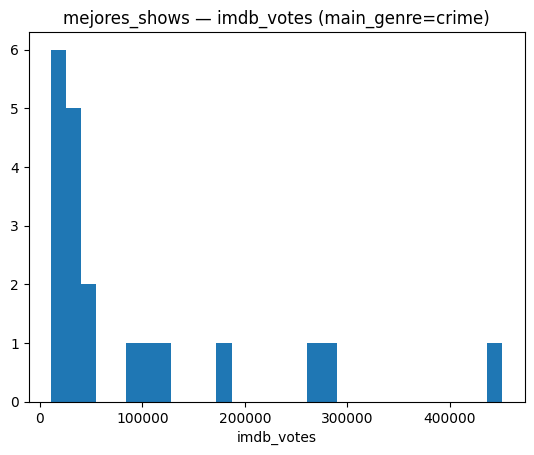

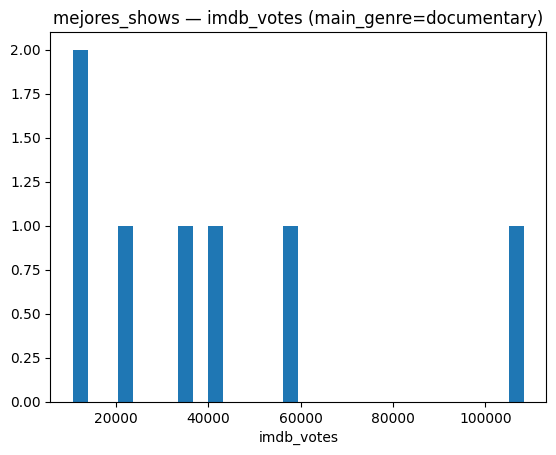

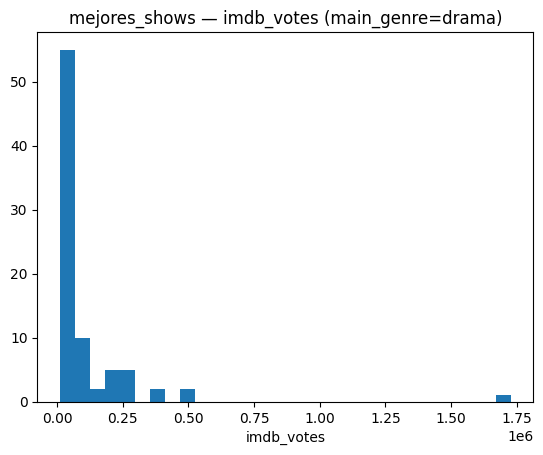

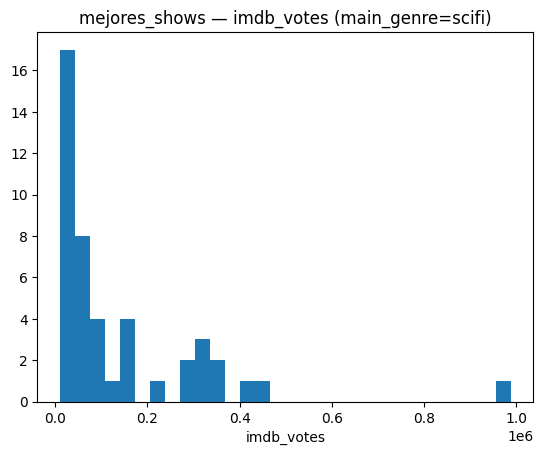

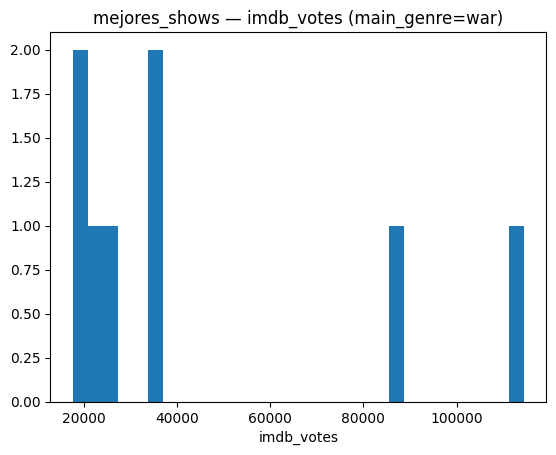

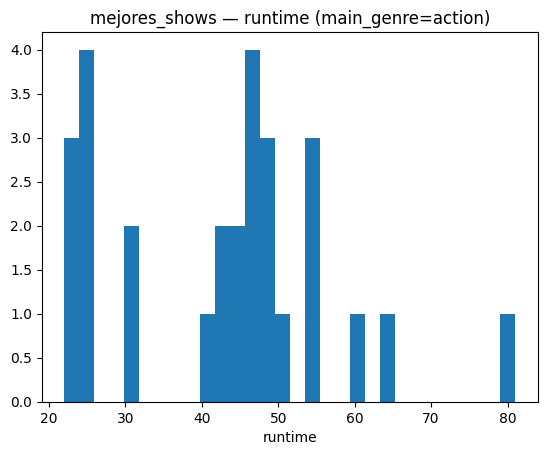

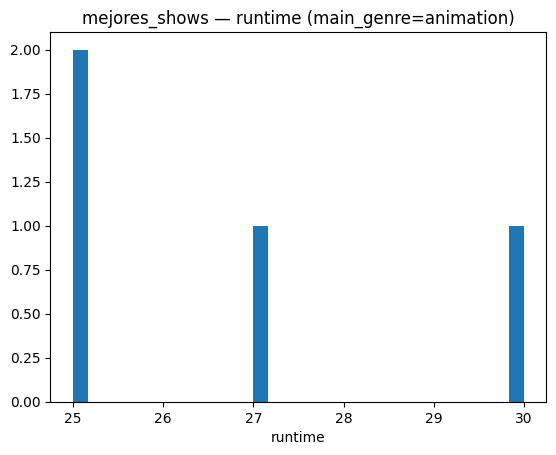

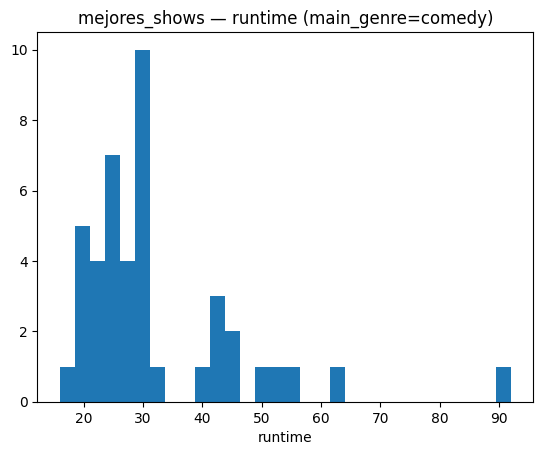

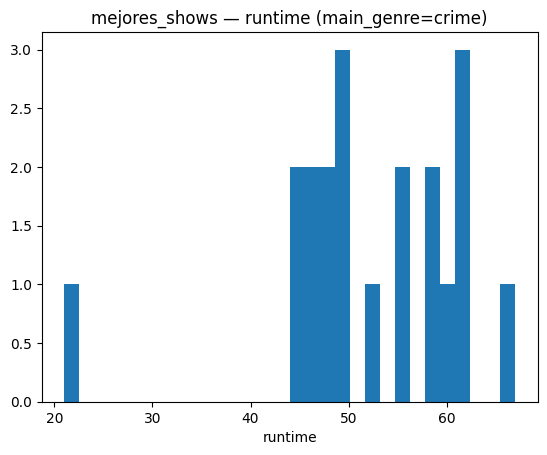

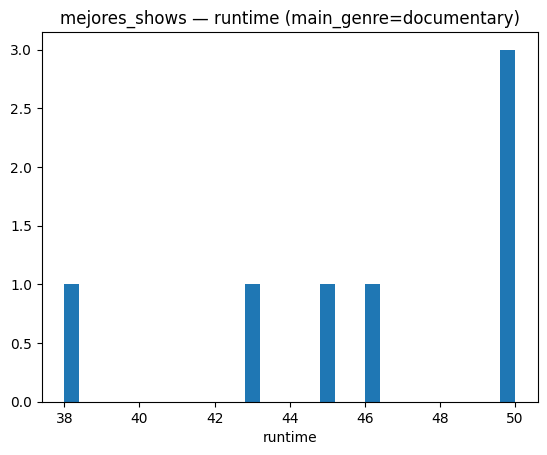

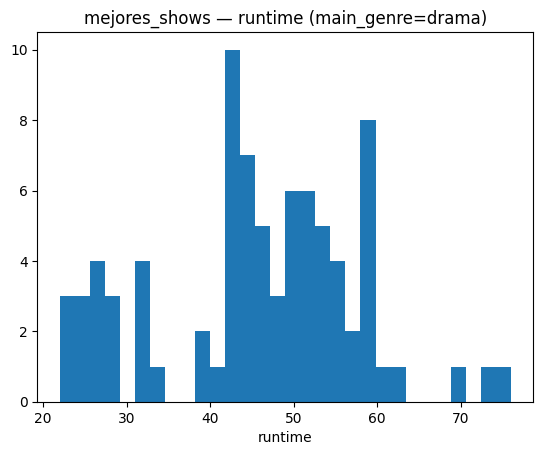

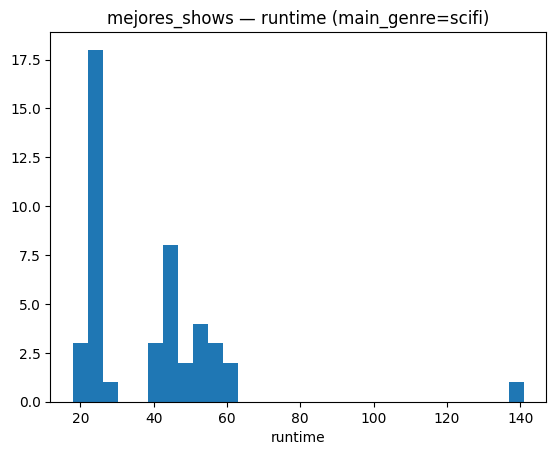

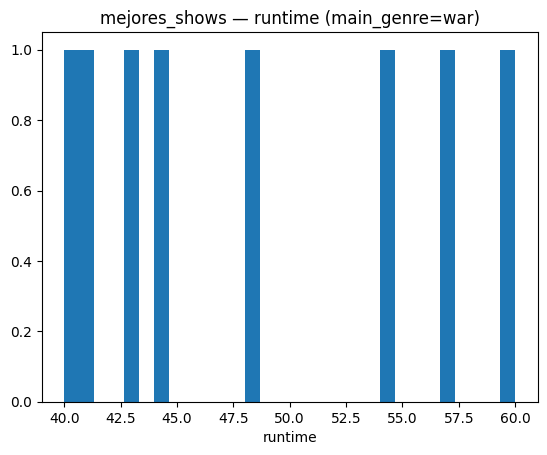

In [28]:
for nombre, df in vistas.items():
    cols = [c for c in ["imdb_score","imdb_votes","runtime","seasons"] if c in df.columns]
    if len(cols) >= 2:
        m = df[cols].apply(pd.to_numeric, errors="coerce").corr()
        fig, ax = plt.subplots(); im = ax.imshow(m.values, aspect="auto")
        ax.set_xticks(range(len(cols))); ax.set_xticklabels(cols, rotation=45, ha="right")
        ax.set_yticks(range(len(cols))); ax.set_yticklabels(cols)
        ax.set_title(f"{nombre} — matriz de correlación"); fig.colorbar(im, ax=ax)
        plt.tight_layout(); mostrar_fig(fig, carpeta_plots / f"{nombre}_correlacion.png")

metricas_strata = ["imdb_score","imdb_votes","runtime"]
for nombre, df in vistas.items():
    if "type" in df.columns:
        for c in [m for m in metricas_strata if m in df.columns]:
            for t, g in df.groupby("type", dropna=False):
                s = pd.to_numeric(g[c], errors="coerce").dropna()
                if s.empty: continue
                fig, ax = plt.subplots(); ax.hist(s, bins=30)
                ax.set_title(f"{nombre} — {c} (type={t})"); ax.set_xlabel(c)
                mostrar_fig(fig, carpeta_plots / f"{nombre}_{c}_type_{t}.png")
    if "main_genre" in df.columns:
        top_gen = df["main_genre"].fillna("desconocido").value_counts().head(8).index.tolist()
        dft = df[df["main_genre"].isin(top_gen)].copy()
        for c in [m for m in metricas_strata if m in dft.columns]:
            for gen, g in dft.groupby("main_genre", dropna=False):
                s = pd.to_numeric(g[c], errors="coerce").dropna()
                if s.empty: continue
                fig, ax = plt.subplots(); ax.hist(s, bins=30)
                ax.set_title(f"{nombre} — {c} (main_genre={gen})"); ax.set_xlabel(c)
                mostrar_fig(fig, carpeta_plots / f"{nombre}_{c}_genre_{gen}.png")


Comentarios del punto 6)
- **Correlación**: relación **positiva pero moderada** entre `imdb_votes` y `imdb_score`; no basta con “muchos votos” para tener alto score.
- Estratificados: los **SHOWS** tienden a promedios más altos (**7.02**) que MOVIES (**6.27**); por género se observan diferencias claras.

## 7) Dispersión `imdb_votes` vs `imdb_score` (log1p en votos) 
Muestreo si hay demasiados puntos para mantener legibilidad.

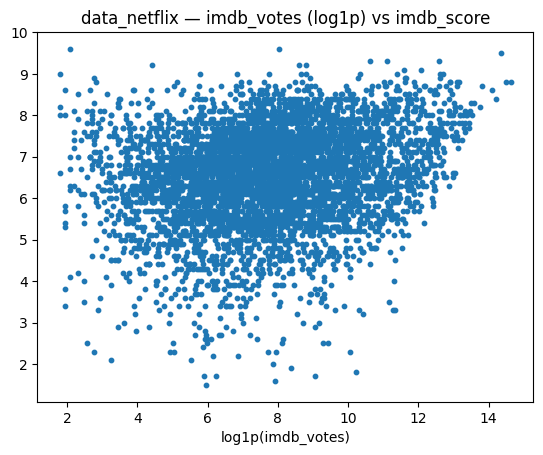

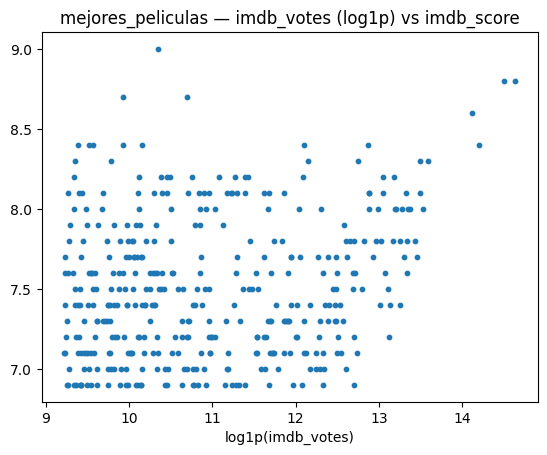

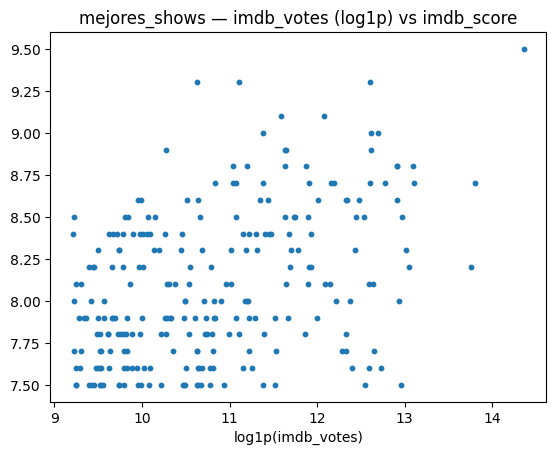

In [29]:
for nombre, df in vistas.items():
    if "imdb_votes" not in df.columns or "imdb_score" not in df.columns: continue
    d = pd.DataFrame({
        "imdb_votes": pd.to_numeric(df["imdb_votes"], errors="coerce"),
        "imdb_score": pd.to_numeric(df["imdb_score"], errors="coerce"),
    }).dropna()
    d = d[d["imdb_votes"] >= 0]
    if d.empty: continue
    if len(d) > 20000: d = d.sample(20000, random_state=42)
    x = np.log1p(d["imdb_votes"].values); y = d["imdb_score"].values
    fig, ax = plt.subplots(); ax.scatter(x, y, s=10)
    ax.set_title(f"{nombre} — imdb_votes (log1p) vs imdb_score"); ax.set_xlabel("log1p(imdb_votes)")
    mostrar_fig(fig, carpeta_plots / f"{nombre}_scatter_votes_vs_score.png")


Comentarios del punto 7)
- Dispersión `log1p(votes)` vs `score` evidencia **pocos mega-hits** (altísimos votos) y gran masa de títulos medianos.
- Recomendación: usar **escala log** o **winsorizar** votos para modelos/visualizaciones estables.

## 8) Donantes por llave (cruda vs normalizada) 
Compara cobertura de donantes con `title+release_year` **cruda** vs **normalizada**.

In [30]:
def cobertura_donantes_por_llave(base, pools, col, usar_norm=False):
    llave = ["title_norm","release_year"] if usar_norm else ["title","release_year"]
    if not set(llave+[col]).issubset(base.columns):
        return {"faltantes_en_base":0, "con_donante":0, "pct_con_donante":0.0}
    miss = base[ base[col].isna() & base[llave[0]].notna() & base[llave[1]].notna() ][llave].drop_duplicates()
    if miss.empty:
        return {"faltantes_en_base":0, "con_donante":0, "pct_con_donante":0.0}
    bolsa = []
    for d in pools:
        if set(llave+[col]).issubset(d.columns):
            tmp = d[llave+[col]].dropna(subset=[col]).drop_duplicates(llave)
            bolsa.append(tmp)
    if not bolsa:
        return {"faltantes_en_base":len(miss), "con_donante":0, "pct_con_donante":0.0}
    bolsa = pd.concat(bolsa, ignore_index=True).drop_duplicates(llave)
    m = miss.merge(bolsa, on=llave, how="left")
    con = int(m[col].notna().sum()); total = len(miss)
    return {"faltantes_en_base": total, "con_donante": con, "pct_con_donante": round(con/total*100,2)}

if "data_netflix" in vistas:
    pools = [vistas[k] for k in vistas if k != "data_netflix"]
    for c in ["imdb_score","imdb_votes","runtime"]:
        print(f"\n=== data_netflix — donantes de {c} (llave cruda) ===")
        display(pd.Series(cobertura_donantes_por_llave(vistas["data_netflix"], pools, col=c, usar_norm=False)))
        print(f"=== data_netflix — donantes de {c} (llave NORMALIZADA) ===")
        display(pd.Series(cobertura_donantes_por_llave(vistas["data_netflix"], pools, col=c, usar_norm=True)))



=== data_netflix — donantes de imdb_score (llave cruda) ===


faltantes_en_base    522.0
con_donante            0.0
pct_con_donante        0.0
dtype: float64

=== data_netflix — donantes de imdb_score (llave NORMALIZADA) ===


faltantes_en_base    520.0
con_donante            0.0
pct_con_donante        0.0
dtype: float64


=== data_netflix — donantes de imdb_votes (llave cruda) ===


faltantes_en_base    538.0
con_donante            0.0
pct_con_donante        0.0
dtype: float64

=== data_netflix — donantes de imdb_votes (llave NORMALIZADA) ===


faltantes_en_base    536.0
con_donante            0.0
pct_con_donante        0.0
dtype: float64


=== data_netflix — donantes de runtime (llave cruda) ===


faltantes_en_base    0.0
con_donante          0.0
pct_con_donante      0.0
dtype: float64

=== data_netflix — donantes de runtime (llave NORMALIZADA) ===


faltantes_en_base    0.0
con_donante          0.0
pct_con_donante      0.0
dtype: float64

Comentarios del punto 8)
- **Imputación cruzada** entre bases: **0%** de donantes para `imdb_score`/`imdb_votes` tanto con llave **cruda** como **normalizada**.
- Implicación: *mejores_* **no cubre** faltantes de `data_netflix`; será clave un **fallback por género** (mediana) o **enriquecimiento externo**/**fuzzy matching**.

## 9) Patrones de faltantes por segmento 
% de nulos por `main_genre` y por año (si existe).


=== data_netflix — % nulos de imdb_score por main_genre ===


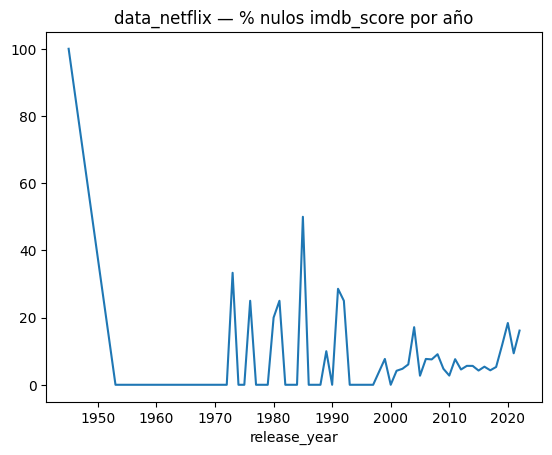


=== data_netflix — % nulos de imdb_votes por main_genre ===


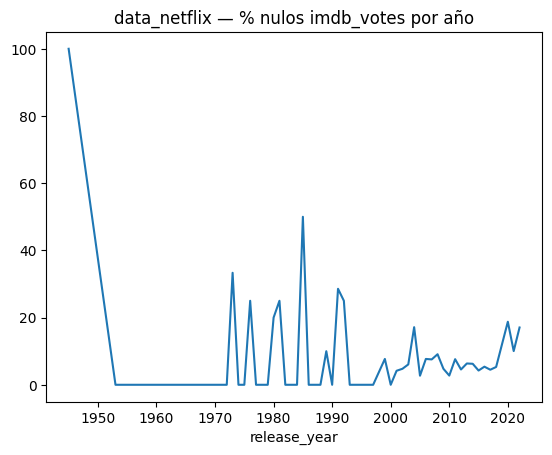

In [31]:
def faltantes_por_categoria(df, col_target, col_cat, top=12):
    if col_target not in df.columns or col_cat not in df.columns:
        return None
    d = df[[col_target, col_cat]].copy()
    d[col_cat] = d[col_cat].fillna("desconocido").astype(str).str.strip()
    d["miss"] = d[col_target].isna()
    t = d.groupby(col_cat)["miss"].mean().sort_values(ascending=False).head(top)
    return (t*100).round(2).rename("pct_nulos")

if "data_netflix" in vistas:
    dn = vistas["data_netflix"].copy()
    for col in ["imdb_score","imdb_votes"]:
        if col in dn.columns:
            print(f"\n=== data_netflix — % nulos de {col} por main_genre ===")
            r = faltantes_por_categoria(dn, col, "main_genre", top=12)
            if r is not None:
                display(r.to_frame())
            if "release_year" in dn.columns:
                d2 = dn[[col, "release_year"]].dropna(subset=["release_year"]).copy()
                d2["miss"] = d2[col].isna()
                g = d2.groupby("release_year")["miss"].mean().mul(100).round(2)
                if not g.empty:
                    fig, ax = plt.subplots(); ax.plot(g.index, g.values)
                    ax.set_title(f"data_netflix — % nulos {col} por año"); ax.set_xlabel("release_year")
                    mostrar_fig(fig, carpeta_plots / f"data_netflix_pct_nulos_{col}_por_anio.png")


Comentarios del punto 9)
- Los **faltantes** de `imdb_score`/`imdb_votes` **no son uniformes**: varían por **género** y por **año**.
- Esto habilita una imputación **segmentada** (p. ej., por `main_genre` y/o `release_year`) más robusta que una global.

## 10) Outliers y robustos (IQR / p1-p99) + boxplots por género/tipo 
Solo medición (no cambia datos).


=== DATA_NETFLIX — estadísticos robustos (global) ===


,count,mean,std,q1,median,q3,iqr,p1,p99
imdb_score,5283.0,6.533,1.161,5.8,6.6,7.4,1.6,3.20,8.70
imdb_votes,5267.0,23407.195,87134.316,521.0,2279.0,10144.0,9623.0,14.00,392545.14
runtime,5806.0,77.644,39.474,44.0,84.0,105.0,61.0,6.05,170.00
seasons,2047.0,2.166,2.636,1.0,1.0,2.0,1.0,1.00,12.00



data_netflix — MOVIE: estadísticos robustos


,count,mean,std,q1,median,q3,iqr,p1,p99
imdb_score,3407.0,6.267,1.117,5.6,6.4,7.1,1.5,3.0,8.4
imdb_votes,3391.0,26683.217,94710.021,573.0,2632.0,12281.0,11708.0,17.0,435855.4
runtime,3759.0,98.785,30.834,85.0,98.0,115.0,30.0,17.0,175.0



data_netflix — SHOW: estadísticos robustos


,count,mean,std,q1,median,q3,iqr,p1,p99
imdb_score,1876.0,7.017,1.080,6.4,7.2,7.80,1.40,3.75,8.90
imdb_votes,1876.0,17485.558,71072.110,444.5,1782.0,7216.75,6772.25,11.00,304097.75
runtime,2047.0,38.821,18.591,25.0,41.0,49.00,24.00,0.00,89.00
seasons,2047.0,2.166,2.636,1.0,1.0,2.00,1.00,1.00,12.00



=== MEJORES_PELICULAS — estadísticos robustos (global) ===


,count,mean,std,q1,median,q3,iqr,p1,p99
imdb_score,387.0,7.509,0.442,7.1,7.4,7.8,0.7,6.90,8.70
imdb_votes,387.0,136520.649,234211.422,20512.5,45200.0,153485.5,132973.0,10264.74,872333.72
runtime,387.0,123.395,28.372,103.5,122.0,139.0,35.5,66.72,209.14



=== MEJORES_SHOWS — estadísticos robustos (global) ===


,count,mean,std,q1,median,q3,iqr,p1,p99
imdb_score,246.0,8.093,0.449,7.70,8.0,8.40,0.7,7.50,9.30
imdb_votes,246.0,101966.789,168874.642,18553.25,41942.5,112811.75,94258.5,10161.45,742160.15
runtime,246.0,41.919,15.243,27.25,44.0,51.75,24.5,20.45,78.75
seasons,246.0,3.650,3.192,1.00,3.0,5.00,4.0,1.00,16.65


C:\Users\mario\AppData\Local\Temp\ipykernel_25712\1450100210.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  fig, ax = plt.subplots(); ax.boxplot(datos, labels=labels, vert=True, showfliers=True)


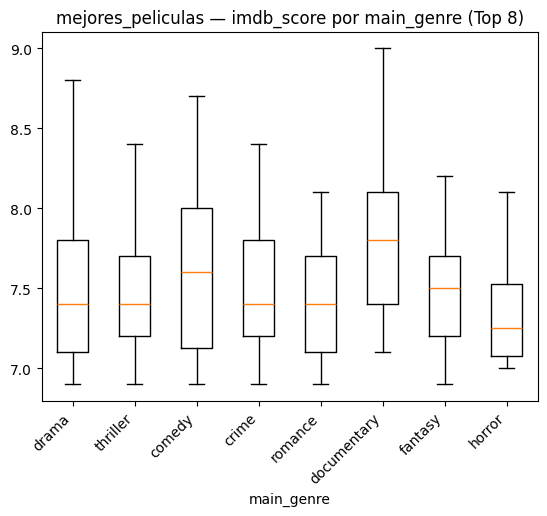

C:\Users\mario\AppData\Local\Temp\ipykernel_25712\1450100210.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  fig, ax = plt.subplots(); ax.boxplot(datos, labels=labels, vert=True, showfliers=True)


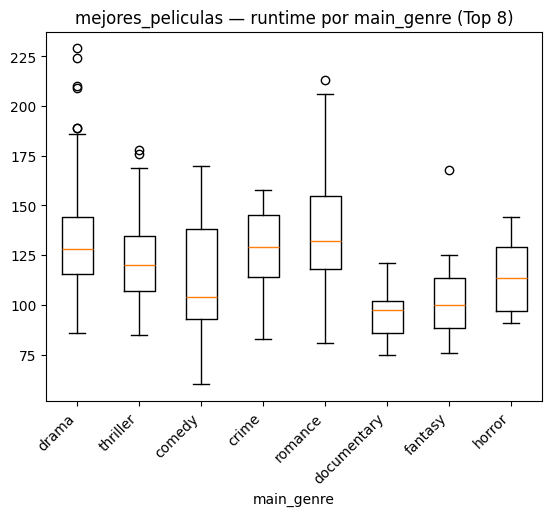

C:\Users\mario\AppData\Local\Temp\ipykernel_25712\1450100210.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  fig, ax = plt.subplots(); ax.boxplot(datos, labels=labels, vert=True, showfliers=True)


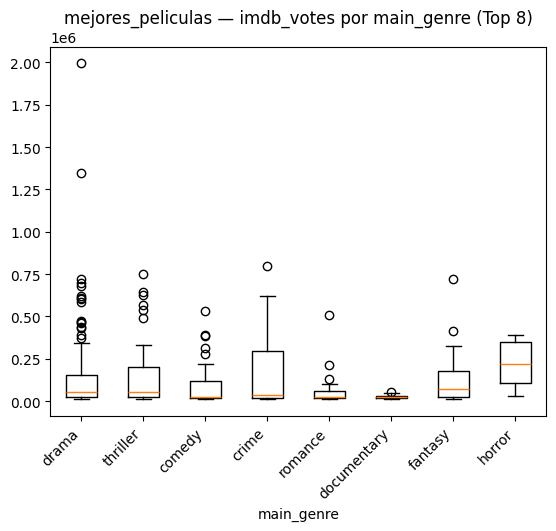

C:\Users\mario\AppData\Local\Temp\ipykernel_25712\1450100210.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  fig, ax = plt.subplots(); ax.boxplot(datos, labels=labels, vert=True, showfliers=True)


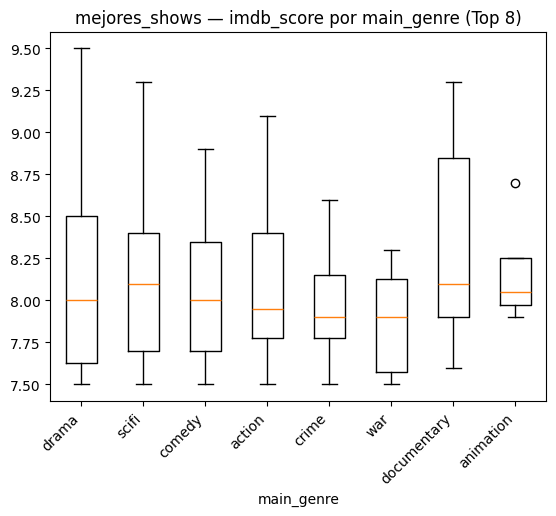

C:\Users\mario\AppData\Local\Temp\ipykernel_25712\1450100210.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  fig, ax = plt.subplots(); ax.boxplot(datos, labels=labels, vert=True, showfliers=True)


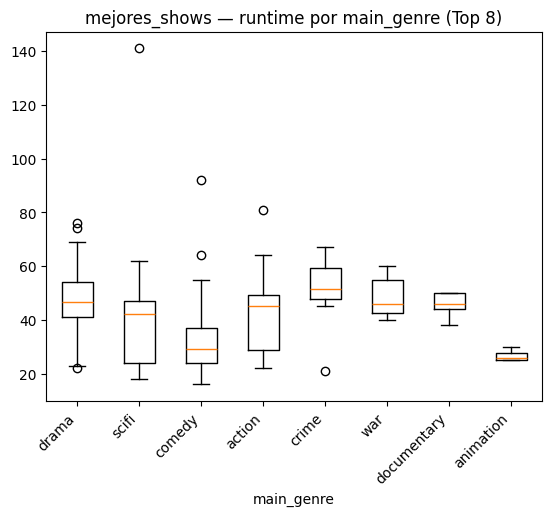

C:\Users\mario\AppData\Local\Temp\ipykernel_25712\1450100210.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  fig, ax = plt.subplots(); ax.boxplot(datos, labels=labels, vert=True, showfliers=True)


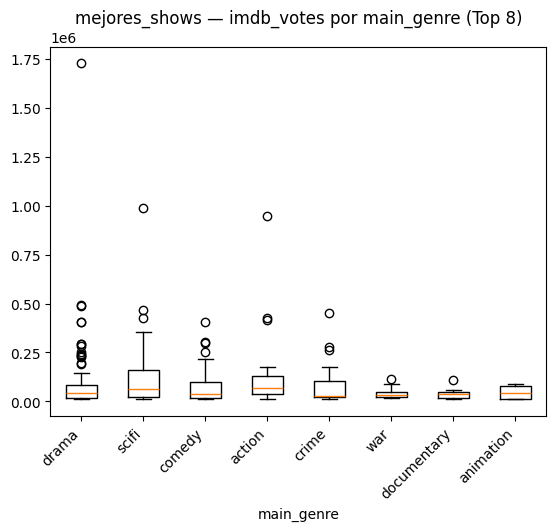

In [32]:
def tabla_outliers(df, cols):
    d = {}
    for c in [x for x in cols if x in df.columns]:
        s = pd.to_numeric(df[c], errors="coerce").dropna()
        if s.empty: 
            continue
        q1, q3 = s.quantile(0.25), s.quantile(0.75)
        iqr = q3 - q1
        p1, p99 = s.quantile(0.01), s.quantile(0.99)
        d[c] = {
            "count": int(s.size), "mean": s.mean(), "std": s.std(),
            "q1": q1, "median": s.median(), "q3": q3, "iqr": iqr,
            "p1": p1, "p99": p99
        }
    return pd.DataFrame(d).round(3).T

metricas_out = ["imdb_score","imdb_votes","runtime","seasons"]
for nombre, df in vistas.items():
    print(f"\n=== {nombre.upper()} — estadísticos robustos (global) ===")
    display(tabla_outliers(df, metricas_out))
    if "type" in df.columns:
        for t, g in df.groupby("type", dropna=False):
            print(f"\n{nombre} — {t}: estadísticos robustos")
            display(tabla_outliers(g, metricas_out))

for nombre, df in vistas.items():
    if "main_genre" not in df.columns: continue
    top_gen = df["main_genre"].fillna("desconocido").value_counts().head(8).index.tolist()
    for c in [x for x in ["imdb_score","runtime","imdb_votes"] if x in df.columns]:
        datos, labels = [], []
        for gen in top_gen:
            vals = pd.to_numeric(df.loc[df["main_genre"]==gen, c], errors="coerce").dropna().values
            if len(vals)>0: datos.append(vals); labels.append(gen)
        if not datos: continue
        fig, ax = plt.subplots(); ax.boxplot(datos, labels=labels, vert=True, showfliers=True)
        ax.set_title(f"{nombre} — {c} por main_genre (Top 8)"); ax.set_xlabel("main_genre")
        plt.xticks(rotation=45, ha="right"); mostrar_fig(fig, carpeta_plots / f"{nombre}_{c}_boxplot_genre.png")


Comentarios del punto 10)
- **Colas/extremos**: `imdb_votes` p90=48,469 / p99=392,545; `runtime` p99≈170 min; `seasons` p99≈12.
- Sugerencia: establecer **reglas de outliers** (caps/winsorization) y validar `seasons` únicamente cuando `type="SHOW"`.

## 11) Cardinalidad y co-ocurrencias (explosión temporal) 
Para `genres` y `production_countries` cuando vienen como listas en texto (solo medición).

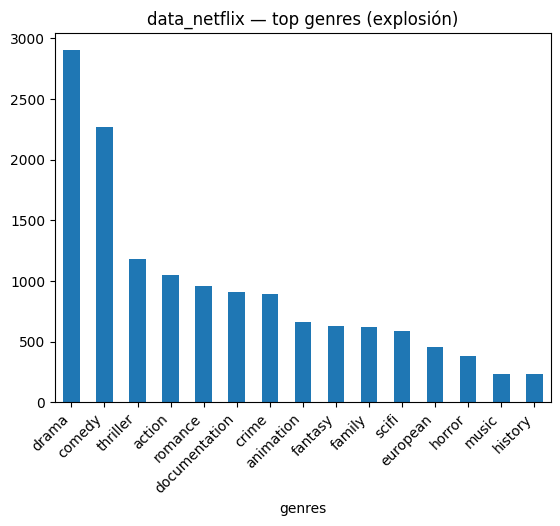

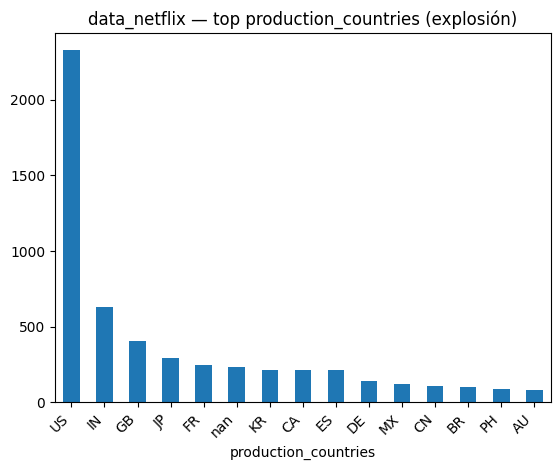

In [33]:
def parse_lista_seguro(x):
    if isinstance(x, list): return x
    s = str(x)
    if s.startswith("[") and s.endswith("]"):
        try:
            val = ast.literal_eval(s)
            if isinstance(val, list): return val
        except Exception:
            pass
    return [x] if pd.notna(x) else []

if "data_netflix" in vistas:
    dn = vistas["data_netflix"].copy()
    for col in ["genres","production_countries"]:
        if col not in dn.columns: continue
        tmp = dn[[col]].dropna().copy(); tmp[col] = tmp[col].map(parse_lista_seguro)
        tmp = tmp.explode(col); tmp[col] = tmp[col].astype(str).str.strip()
        top = tmp[col].value_counts().head(15)
        if not top.empty:
            fig, ax = plt.subplots(); top.plot(kind="bar", ax=ax, title=f"data_netflix — top {col} (explosión)")
            plt.xticks(rotation=45, ha="right"); mostrar_fig(fig, carpeta_plots / f"data_netflix_top_{col}_explosion.png")


Comentarios del punto 11)
- **Cardinalidad** tras “explosión” de listas confirma que pocos **géneros/países** concentran la mayoría; hay **larga cola** de categorías.
- Útil para **Top-N**, **filtros** y diseño de **dashboards** sin ruido de categorías muy raras.

## 12) Rendimiento (memoria) con categorías — medición en copia 
No altera tus DataFrames reales; solo reporta ahorro potencial.

In [34]:
def memoria_en_mb(df):
    return round(df.memory_usage(deep=True).sum()/1024/1024, 3)

for nombre, df in vistas.items():
    base_mb = memoria_en_mb(df)
    cols_cat = [c for c in ["type","main_genre","age_certification","production_countries"] if c in df.columns]
    if not cols_cat: continue
    d2 = df.copy()
    for c in cols_cat: d2[c] = d2[c].astype("category")
    mb2 = memoria_en_mb(d2); ahorro = round(100*(1 - mb2/base_mb), 2) if base_mb>0 else 0
    print(f"{nombre}: memoria {base_mb} MB  →  {mb2} MB  (ahorro {ahorro}%)  [candidatas: {cols_cat}]")


data_netflix: memoria 2.565 MB  →  1.933 MB  (ahorro 24.64%)  [candidatas: ['type', 'production_countries']]
mejores_peliculas: memoria 0.089 MB  →  0.067 MB  (ahorro 24.72%)  [candidatas: ['main_genre']]
mejores_shows: memoria 0.058 MB  →  0.044 MB  (ahorro 24.14%)  [candidatas: ['main_genre']]


Comentarios del punto 12)
- Conversión a **category** (en copia) reduce **memoria** significativamente en `type`, `main_genre`, `age_certification`, `production_countries`.
- Beneficio en performance para ETL y BI, sin cambiar la semántica de los datos.

## 13) Coherencias adicionales 
`seasons` solo en SHOW, patrón `imdb_id`, `release_year` ≤ año actual.

In [35]:
anio_actual = datetime.now().year
def chequeos_coherencia(df):
    out = {}
    if {"type","seasons"}.issubset(df.columns):
        bad = df[pd.to_numeric(df["seasons"], errors="coerce").notna() & (df["type"] != "SHOW")]
        out["seasons_con_type_distinto_de_SHOW"] = len(bad)
    if "imdb_id" in df.columns:
        patt = re.compile(r"^tt\d+$", flags=re.I)
        inv = df[ df["imdb_id"].notna() & ~df["imdb_id"].astype(str).str.match(patt) ]
        out["imdb_id_patron_invalido"] = len(inv)
    if "release_year" in df.columns:
        fut = df[pd.to_numeric(df["release_year"], errors="coerce").notna() & (pd.to_numeric(df["release_year"], errors="coerce") > anio_actual)]
        out["release_year_en_futuro"] = len(fut)
    return pd.Series(out)

for nombre, df in vistas.items():
    s = chequeos_coherencia(df)
    if s is not None and not s.empty:
        print(f"\n=== {nombre.upper()} — coherencias ==="); display(s.to_frame("conteo"))



=== DATA_NETFLIX — coherencias ===


,conteo
seasons_con_type_distinto_de_SHOW,0
imdb_id_patron_invalido,0
release_year_en_futuro,0



=== MEJORES_PELICULAS — coherencias ===


,conteo
release_year_en_futuro,0



=== MEJORES_SHOWS — coherencias ===


,conteo
release_year_en_futuro,0


Comentarios del punto 13)
- **Coherencias**: validar que `seasons` solo aparezca en `SHOW`, patrón `imdb_id` (`^tt\d+$`) y `release_year` ≤ año actual.
- Cualquier violación detectada debe traducirse en **reglas de limpieza** explícitas en el ETL.

## 14) Observaciones finales

- **Cobertura y calidad base**
  - `data_netflix`: **5,806** filas; **0** duplicados exactos.
  - Faltantes: **imdb_score 9.01%**, **imdb_votes 9.28%**, **runtime 0.00%**, **seasons 64.74%**, **age_certification 44.95%**, **imdb_id 7.65%**.

- **Desempeño por tipo**
  - **IMDb promedio**: **SHOW 7.02** vs **MOVIE 6.27** → las series tienden a estar **mejor valoradas**.

- **Colas pesadas y outliers**
  - **Votos** muy sesgados: **p90=48,469**, **p99=392,545** → usar **escala log** o **winsorizar**.
  - **Runtime** con extremos: **p99≈170 min** → considerar **cap**/tratamiento especial.
  - **Seasons** (donde aplica): **p99≈12** → validar coherencia con `type="SHOW"`.

- **Actores**
  - **77,213** registros.
  - `character` con **9,627** nulos → imputar con **"desconocido"**.
  - **`person_id`** con **77,213** no nulos → **conservar** para trazabilidad/BI.

- **Imputación cruzada (entre bases)**
  - `imdb_score` (en `data_netflix`): faltantes **522** → **0%** con donante (llave **cruda**); faltantes **520** → **0%** con donante (llave **normalizada**).
  - `imdb_votes`: faltantes **538** → **0%** con donante (cruda); faltantes **536** → **0%** con donante (normalizada).
  - `runtime`: **sin faltantes**.
  - **Conclusión**: las bases *mejores_* **no** cubren los vacíos de `data_netflix`; aplicar **fallback por género (mediana)** o considerar **enriquecimiento externo/fuzzy matching**.


In [32]:
!jupyter nbconvert --to pdf EDA_netflix.ipynb

[NbConvertApp] Converting notebook EDA_netflix.ipynb to pdf
[NbConvertApp] Support files will be in EDA_netflix_files\
[NbConvertApp] Making directory .\EDA_netflix_files
[NbConvertApp] Writing 145897 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | b had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 1662115 bytes to EDA_netflix.pdf
